In [16]:
import os
from glob import glob
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
from scipy.optimize import lsq_linear
from sklearn.linear_model import LinearRegression
import pickle
import seaborn as sns
from datetime import date

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline 

## Configuration

### Plotting styling

In [4]:
colors = {}
#Expert algos
colors['Threshold0'] = 'black'
colors['Threshold'] = 'black'
colors['Mixedbcstcsig5'] = 'red'

colors['AEttbar'] = 'tab:blue'
colors['AElphe'] = 'tab:orange'
colors['AEtele'] = 'tab:blue'

styles = {}
styles['Threshold0'] = '-'
styles['Threshold'] = '-.'
styles['Mixedbcstcsig5'] = '-.'
styles['AEttbar'] = '-'
styles['AElphe'] = '-'
styles['AEtele'] = '-'

legends = {}
legends['Threshold0'] = 'All trigger cells'
legends['Threshold'] = 'Threshold 1.35 mipT'
legends['Mixedbcstcsig5'] = 'Real BC+STC 5' 

legends['AEttbar'] = 'ttbar'
legends['AElphe'] = 'EMD NN loss'
legends['AEtele'] = 'Telescope loss'

ref_name = 'Threshold0'

### Input files and FE algorithms to be studied
Both 200PU electron gun and 0PU photon guns are loaded

In [17]:
#Make new image directory for today's updates

today = date.today().strftime("%m_%d_%y")

fig_dir=os.path.join('/ecoderemdvol/paper_plots/{}/physics/').format(today)

if not os.path.exists(img_directory):
    os.makedirs(img_directory)

In [8]:
algo_files = {}

# Read  old FE set
directory = '/ecoderemdvol/paper_plots/physics'
fes = ['AEtele','AElphe']
for fe in fes:
    algo_files[fe] = (glob(directory+'/electrons/*.hdf5'), glob(directory+'/photons/*.hdf5'))

## Loading and preprocessing dataframes

In [9]:
algos_dfs = {}
for fe,files in algo_files.items():
    name = fe
    dfs = []
    for file in files[0]:
        store = pd.HDFStore(file, mode='r')
        dfs.append(store[name])
        store.close()
    for file in files[1]:
        store = pd.HDFStore(file, mode='r')
        dfs.append(store[name])
        store.close()
    algos_dfs[fe] = pd.concat(dfs)
algo_names = sorted(algos_dfs.keys())

Selection cuts (in addition to those already applied before):
- Gen particle $p_T > 5 GeV$
- Cluster $p_T > 3 GeV$
- Extrapolated gen particle eta between 1.6 and 2.9

Additionally label electrons and positrons as `0` and photons as `1`.

In [10]:
ptcut=5
clptcut=3
etamin=1.6
etamax=2.9
algo_cut={}
for name,df in algos_dfs.items():
    sel = df['genpart_pt']>ptcut
    algo_cut[name] = df[sel]
    sel = algo_cut[name]['cl3d_pt']>clptcut
    algo_cut[name] = algo_cut[name][sel]
    sel = np.abs(algo_cut[name]['genpart_exeta'])>etamin
    algo_cut[name] = algo_cut[name][sel]
    sel = np.abs(algo_cut[name]['genpart_exeta'])<etamax
    algo_cut[name] = algo_cut[name][sel]
    sel = algo_cut[name]['matches']==True
    algo_cut[name] = algo_cut[name][sel]
    #algo_cut[name].dropna(inplace=True)
    algo_cut[name]['genpart_pid'].replace([-11,11],1, inplace=True)
    algo_cut[name]['genpart_pid'].replace([22],0, inplace=True)

In [11]:
for name,df in algo_cut.items():
    df['cl3d_abseta'] = np.abs(df.cl3d_eta)

## Energy corrections
### Layer weights
On 0PU photon clusters:
- Select layer pTs in the ECAL, dropping the first layer as it doesn't bring anything in the e/g energy and is polluted by PU
- Apply linear regression to find multiplicative coeff. to be applied to each layer pT. These coeff. are bounded between 0 and 2 to avoid large correction factors

In [12]:
layer_coeffs = {}
for name,df in algo_cut.items():
    print(name)
    # select layers [2,14]
    select = df.query('genpart_pid==0')
    layers = np.array(select['cl3d_layer_pt'].tolist())[:,2:15]
    regression = lsq_linear(layers, select['genpart_pt'],
                              bounds = (0.,2.0),
                              method='bvls',
                              lsmr_tol='auto',
                              verbose=1)
    layer_coeffs[name] = regression.x
    print(regression.x)

AEtele
The relative change of the cost function is less than `tol`.
Number of iterations 4, initial cost 2.1740e+05, final cost 2.0933e+05, first-order optimality 2.00e-08.
[1.68507147 1.07422017 1.15782576 1.15547402 1.08769841 1.15013506
 1.16663521 1.11372918 1.02829662 0.96031496 1.33751982 2.
 2.        ]
AElphe
The relative change of the cost function is less than `tol`.
Number of iterations 3, initial cost 1.4555e+05, final cost 1.3828e+05, first-order optimality 6.25e-09.
[1.53412688 0.98080526 1.04683005 1.04703702 1.01348249 1.09295672
 1.04553572 1.03196887 0.95218221 0.8630478  1.05883649 1.95532629
 2.        ]


Apply layer weights and compute ratios wrt the gen $p_T$ and plot the weight values

In [13]:
# Apply calibration
for name,df in algo_cut.items():
    layers = np.array(df['cl3d_layer_pt'].tolist())[:,2:15]
    df['cl3d_pt_calib'] = np.dot(layers, layer_coeffs[name])
    df['cl3d_over_gen_pt'] = df['cl3d_pt']/df['genpart_pt']
    df['calib_over_gen_pt'] = df['cl3d_pt_calib']/df['genpart_pt']

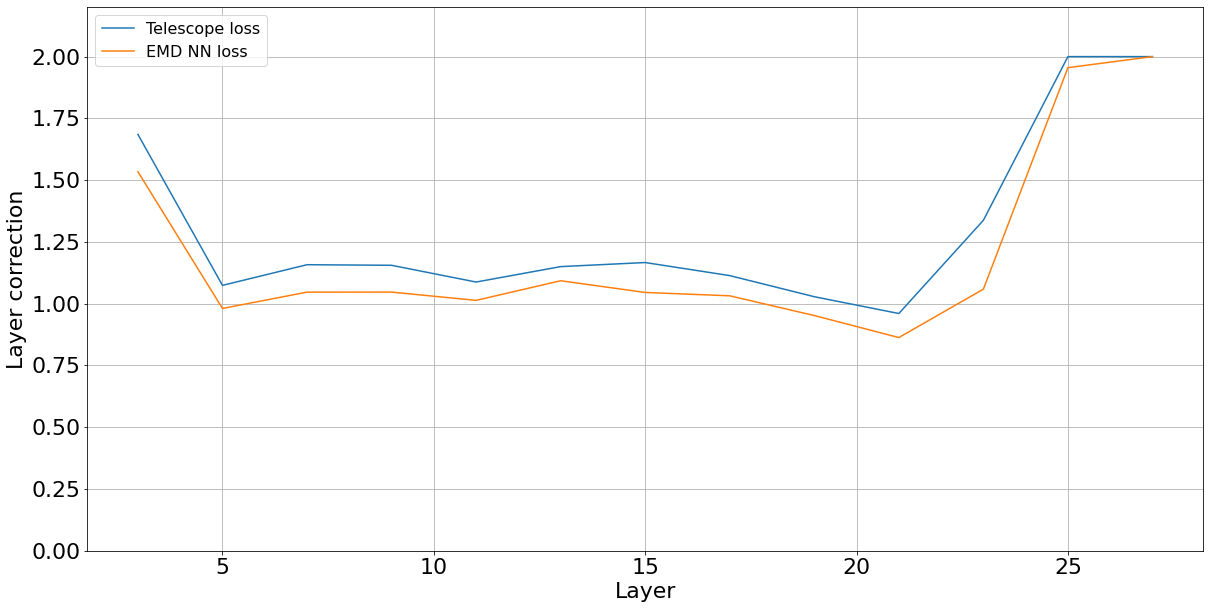

In [18]:
matplotlib.rcParams.update({'font.size': 22})
plt.figure(figsize=(20,10))
for name,weights in layer_coeffs.items():
    plt.plot(range(3, 29, 2), weights, label=legends[name], color=colors[name], ls=styles[name])
plt.ylim(0., 2.2)
plt.legend(fontsize=16)
plt.grid()
plt.xlabel('Layer')
plt.ylabel('Layer correction')
plt.savefig(fig_dir+'/layer_corrections.png')
plt.show()

Check impact of layer corrections on the energy ratio distributions

Raw mean=0.8735678791999817, rms=0.04540431872010231, rms/mean=0.051975719118340105
Calib mean=0.9958367429276119, rms=0.0540833067020456, rms/mean=0.054309410740407835


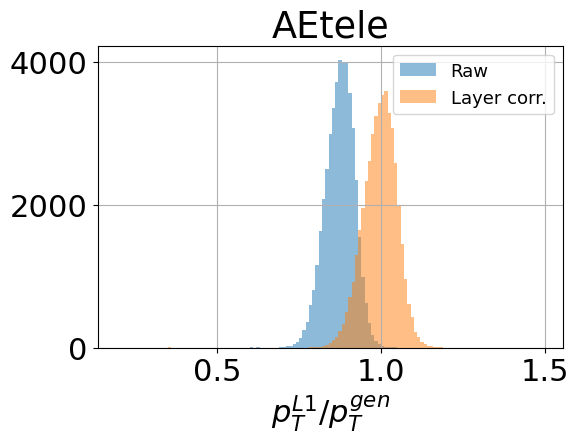

Raw mean=0.9501040577888489, rms=0.04061383754014969, rms/mean=0.04274672569515087
Calib mean=0.9949896490147703, rms=0.04556646308093238, rms/mean=0.045795916697276076


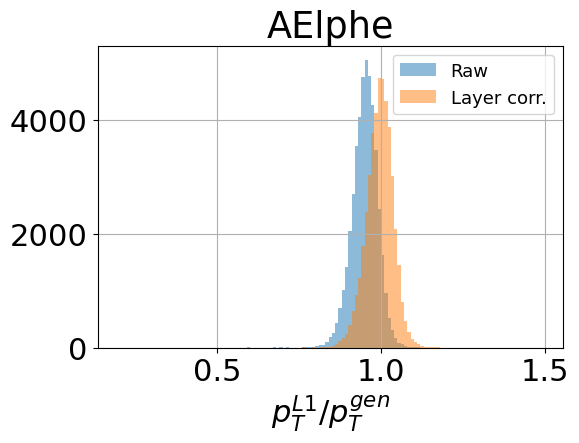

In [19]:
for name,df in algo_cut.items():
    select = df.query('genpart_pid==0')
    print('Raw mean={0}, rms={1}, rms/mean={2}'.format(
        select['cl3d_over_gen_pt'].mean(),
        select['cl3d_over_gen_pt'].std(),
        select['cl3d_over_gen_pt'].std()/select['cl3d_over_gen_pt'].mean()
    ))
    print('Calib mean={0}, rms={1}, rms/mean={2}'.format(
        select['calib_over_gen_pt'].mean(),
        select['calib_over_gen_pt'].std(),
        select['calib_over_gen_pt'].std()/select['calib_over_gen_pt'].mean()
    ))
    
    plt.figure(dpi=100)
    plt.hist(select['cl3d_over_gen_pt'], bins=np.arange(0.2, 1.5, 0.01), alpha=0.5, label='Raw')
    plt.hist(select['calib_over_gen_pt'], bins=np.arange(0.2, 1.5, 0.01), alpha=0.5, label='Layer corr.')
    plt.title(name)
    plt.legend(fontsize=13)
    plt.xlabel(r'$p_{T}^{L1}/p_{T}^{gen}$')
    plt.grid()
    plt.savefig(fig_dir+'/energy_ratio_'+name+'.png')
    plt.show()

## eta correction
On 200PU electrons, on top of the layer correction.

Simple linear correction vs eta to correct for PU. This correction is additive, not multiplicative.

In [20]:
corrs = {}
corrs['eta'] = {}
for name,df in algo_cut.items():
    print('  '+name)
    select = df.query('genpart_pid==1')
    X = select[['cl3d_abseta']]
    y = select['genpart_pt']-select['cl3d_pt_calib']
    corrs['eta'][name] = LinearRegression().fit(X, y)

  AEtele
  AElphe


Print correction value at eta=1.5 and eta=3

In [21]:
for name,df in algo_cut.items():
    corr = corrs['eta'][name]
    print(name)
    print('  eta=1.5:', corr.intercept_+corr.coef_*1.5)
    print('  eta=3:', corr.intercept_+corr.coef_*3)

AEtele
  eta=1.5: [7.410433]
  eta=3: [-14.8764515]
AElphe
  eta=1.5: [7.1478195]
  eta=3: [-15.439011]


In [22]:
for name,df in algo_cut.items():
    df['cl3d_corr_eta'] = corrs['eta'][name].predict(df[['cl3d_abseta']])
    df['cl3d_pt_corr_eta'] =  df['cl3d_corr_eta']+df.cl3d_pt_calib
    df['corr_eta_over_gen_pt'] = df['cl3d_pt_corr_eta']/df['genpart_pt']    

Raw mean=0.9637534022331238, rms=0.20815514028072357, rms/mean=0.2159838188881149
Calib mean=1.087916920211874, rms=0.21248624648182096, rms/mean=0.19531477315422105
Corr eta mean=0.9967414695754713, rms=0.15706814193852087, rms/mean=0.15758162646269627


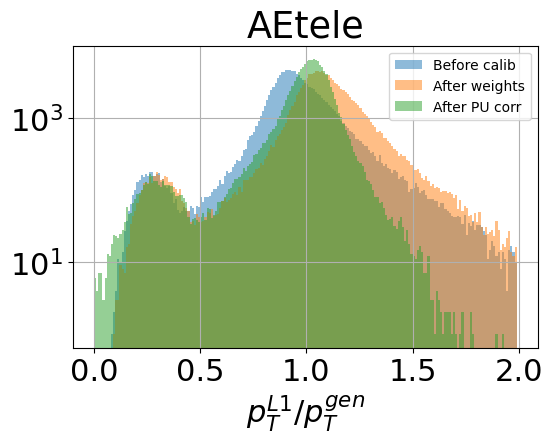

Raw mean=1.057088851928711, rms=0.2321726381778717, rms/mean=0.21963398606868403
Calib mean=1.0956695216389787, rms=0.22155559828148144, rms/mean=0.20221024123228615
Corr eta mean=0.9941479616087765, rms=0.1729776734343367, rms/mean=0.17399590414531071


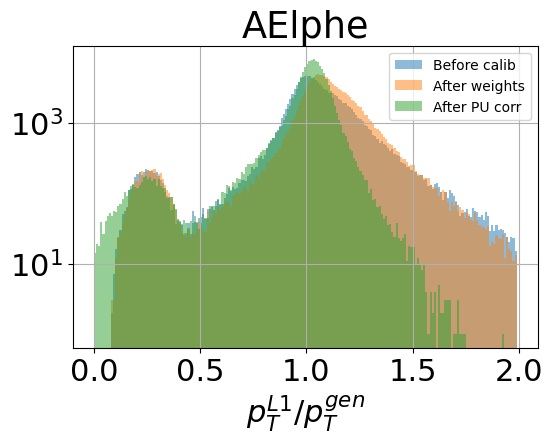

In [23]:
for name,df in algo_cut.items():
    select = df.query('genpart_pid==1 and genpart_pt>10')
    print('Raw mean={0}, rms={1}, rms/mean={2}'.format(
        select['cl3d_over_gen_pt'].mean(),
        select['cl3d_over_gen_pt'].std(),
        select['cl3d_over_gen_pt'].std()/select['cl3d_over_gen_pt'].mean()
    ))
    print('Calib mean={0}, rms={1}, rms/mean={2}'.format(
        select['calib_over_gen_pt'].mean(),
        select['calib_over_gen_pt'].std(),
        select['calib_over_gen_pt'].std()/select['calib_over_gen_pt'].mean()
    ))
    print('Corr eta mean={0}, rms={1}, rms/mean={2}'.format(
        select['corr_eta_over_gen_pt'].mean(),
        select['corr_eta_over_gen_pt'].std(),
        select['corr_eta_over_gen_pt'].std()/select['corr_eta_over_gen_pt'].mean()
    ))
    #plt.figure(figsize=(15,10))
    plt.figure(dpi=100)
    plt.hist(select['cl3d_over_gen_pt'], bins=np.arange(0., 2., 0.01), alpha=0.5, label='Before calib')
    plt.hist(select['calib_over_gen_pt'], bins=np.arange(0., 2., 0.01), alpha=0.5, label='After weights')
    plt.hist(select['corr_eta_over_gen_pt'], bins=np.arange(0., 2., 0.01), alpha=0.5, label='After PU corr')
    plt.grid()
    plt.legend(loc = 'upper right', fontsize=10)
    plt.yscale('log')
    plt.title(name)
    plt.xlabel(r'$p_{T}^{L1}/p_{T}^{gen}$')
    plt.savefig(fig_dir+'/eta_corrections'+name+'.png')
    plt.show()

## Final plots
### For electrons with 200PU, looking at $p_T > 10\,GeV$
First bin in eta and pT

In [24]:
binetasize = 0.1
binptsize = 5
for name, df in algo_cut.items():
    df['genpart_abseta'] = np.abs(df.genpart_exeta)
    df['genpart_bineta'] = (
        (df.genpart_abseta - etamin)/binetasize).astype('int32')
    df['genpart_binpt'] = (df.genpart_pt/binptsize).astype('int32')

Compute the mean, RMS, and effective RMS of the pT ratios in each eta and pT bin

In [68]:
def effrms(df, c=0.68):
    """Compute half-width of the shortest interval
    containing a fraction 'c' of items in a 1D array.
    """
    out = {}
    for col in df:
        x = df[col]
        x = np.sort(x, kind="mergesort")
        m = int(c * len(x)) + 1
        out[col] = [np.min(x[m:] - x[:-m]) / 2.0]
    return pd.DataFrame(out).iloc[0]

In [81]:
tele_eta = algo_cut['AEtele']['genpart_abseta'].values
tele_pt = algo_cut['AEtele']['corr_eta_over_gen_pt'].values

emd_eta = algo_cut['AElphe']['genpart_abseta'].values
emd_pt = algo_cut['AElphe']['corr_eta_over_gen_pt'].values

In [95]:
physics_results_tele = pd.DataFrame(columns=['tele_eta','tele_pt'])
physics_results_emd =  pd.DataFrame(columns=['emd_eta','emd_pt'])

In [96]:
physics_results_tele['tele_eta'] = tele_eta
physics_results_tele['tele_pt']  = tele_pt

physics_results_emd['emd_eta'] = emd_eta
physics_results_emd['emd_pt']  = emd_pt

In [97]:
physics_results_tele.to_csv('/ecoderemdvol/paper_plots/physics/tele.csv')
physics_results_emd.to_csv('/ecoderemdvol/paper_plots/physics/emd.csv')

In [70]:
etameans = {} 
etarmss = {} 
etaeffrmss = {} 
ptmeans = {} 
ptrmss = {} 
pteffrmss = {}
both_means={}
both_eff_rms={}
both_full_rms={}
plot_var = ['genpart_pt', 'genpart_abseta',
            'genpart_bineta', 'genpart_binpt',
           'cl3d_pt', 'cl3d_abseta', 'cl3d_pt_calib',
           'cl3d_pt_corr_eta', 'cl3d_over_gen_pt',
           'calib_over_gen_pt', 'corr_eta_over_gen_pt']


for name,df in algo_cut.items():
    select = df.query('genpart_pid==1 and genpart_pt>10')
    etameans[name] = select[plot_var].groupby('genpart_bineta').mean()
    etarmss[name] = select[plot_var].groupby('genpart_bineta').std()
    etaeffrmss[name] = select[plot_var].groupby('genpart_bineta').apply(effrms)
    ptmeans[name] = select[plot_var].groupby('genpart_binpt').mean()
    ptrmss[name] = select[plot_var].groupby('genpart_binpt').std()
    pteffrmss[name] = select[plot_var].groupby('genpart_binpt').apply(effrms)
    both_means[name]=select[plot_var].groupby(['genpart_binpt','genpart_bineta']).mean()
    both_eff_rms[name]=select[plot_var].groupby(['genpart_binpt','genpart_bineta']).apply(effrms)
    both_full_rms[name]=select[plot_var].groupby(['genpart_binpt','genpart_bineta']).std()

In [27]:
plotted_algo = ['AEtele','AElphe']

In [29]:
import mplhep as hep
hep.style.use("CMS")
mpl.rcParams['figure.dpi'] = 300

Mean vs eta


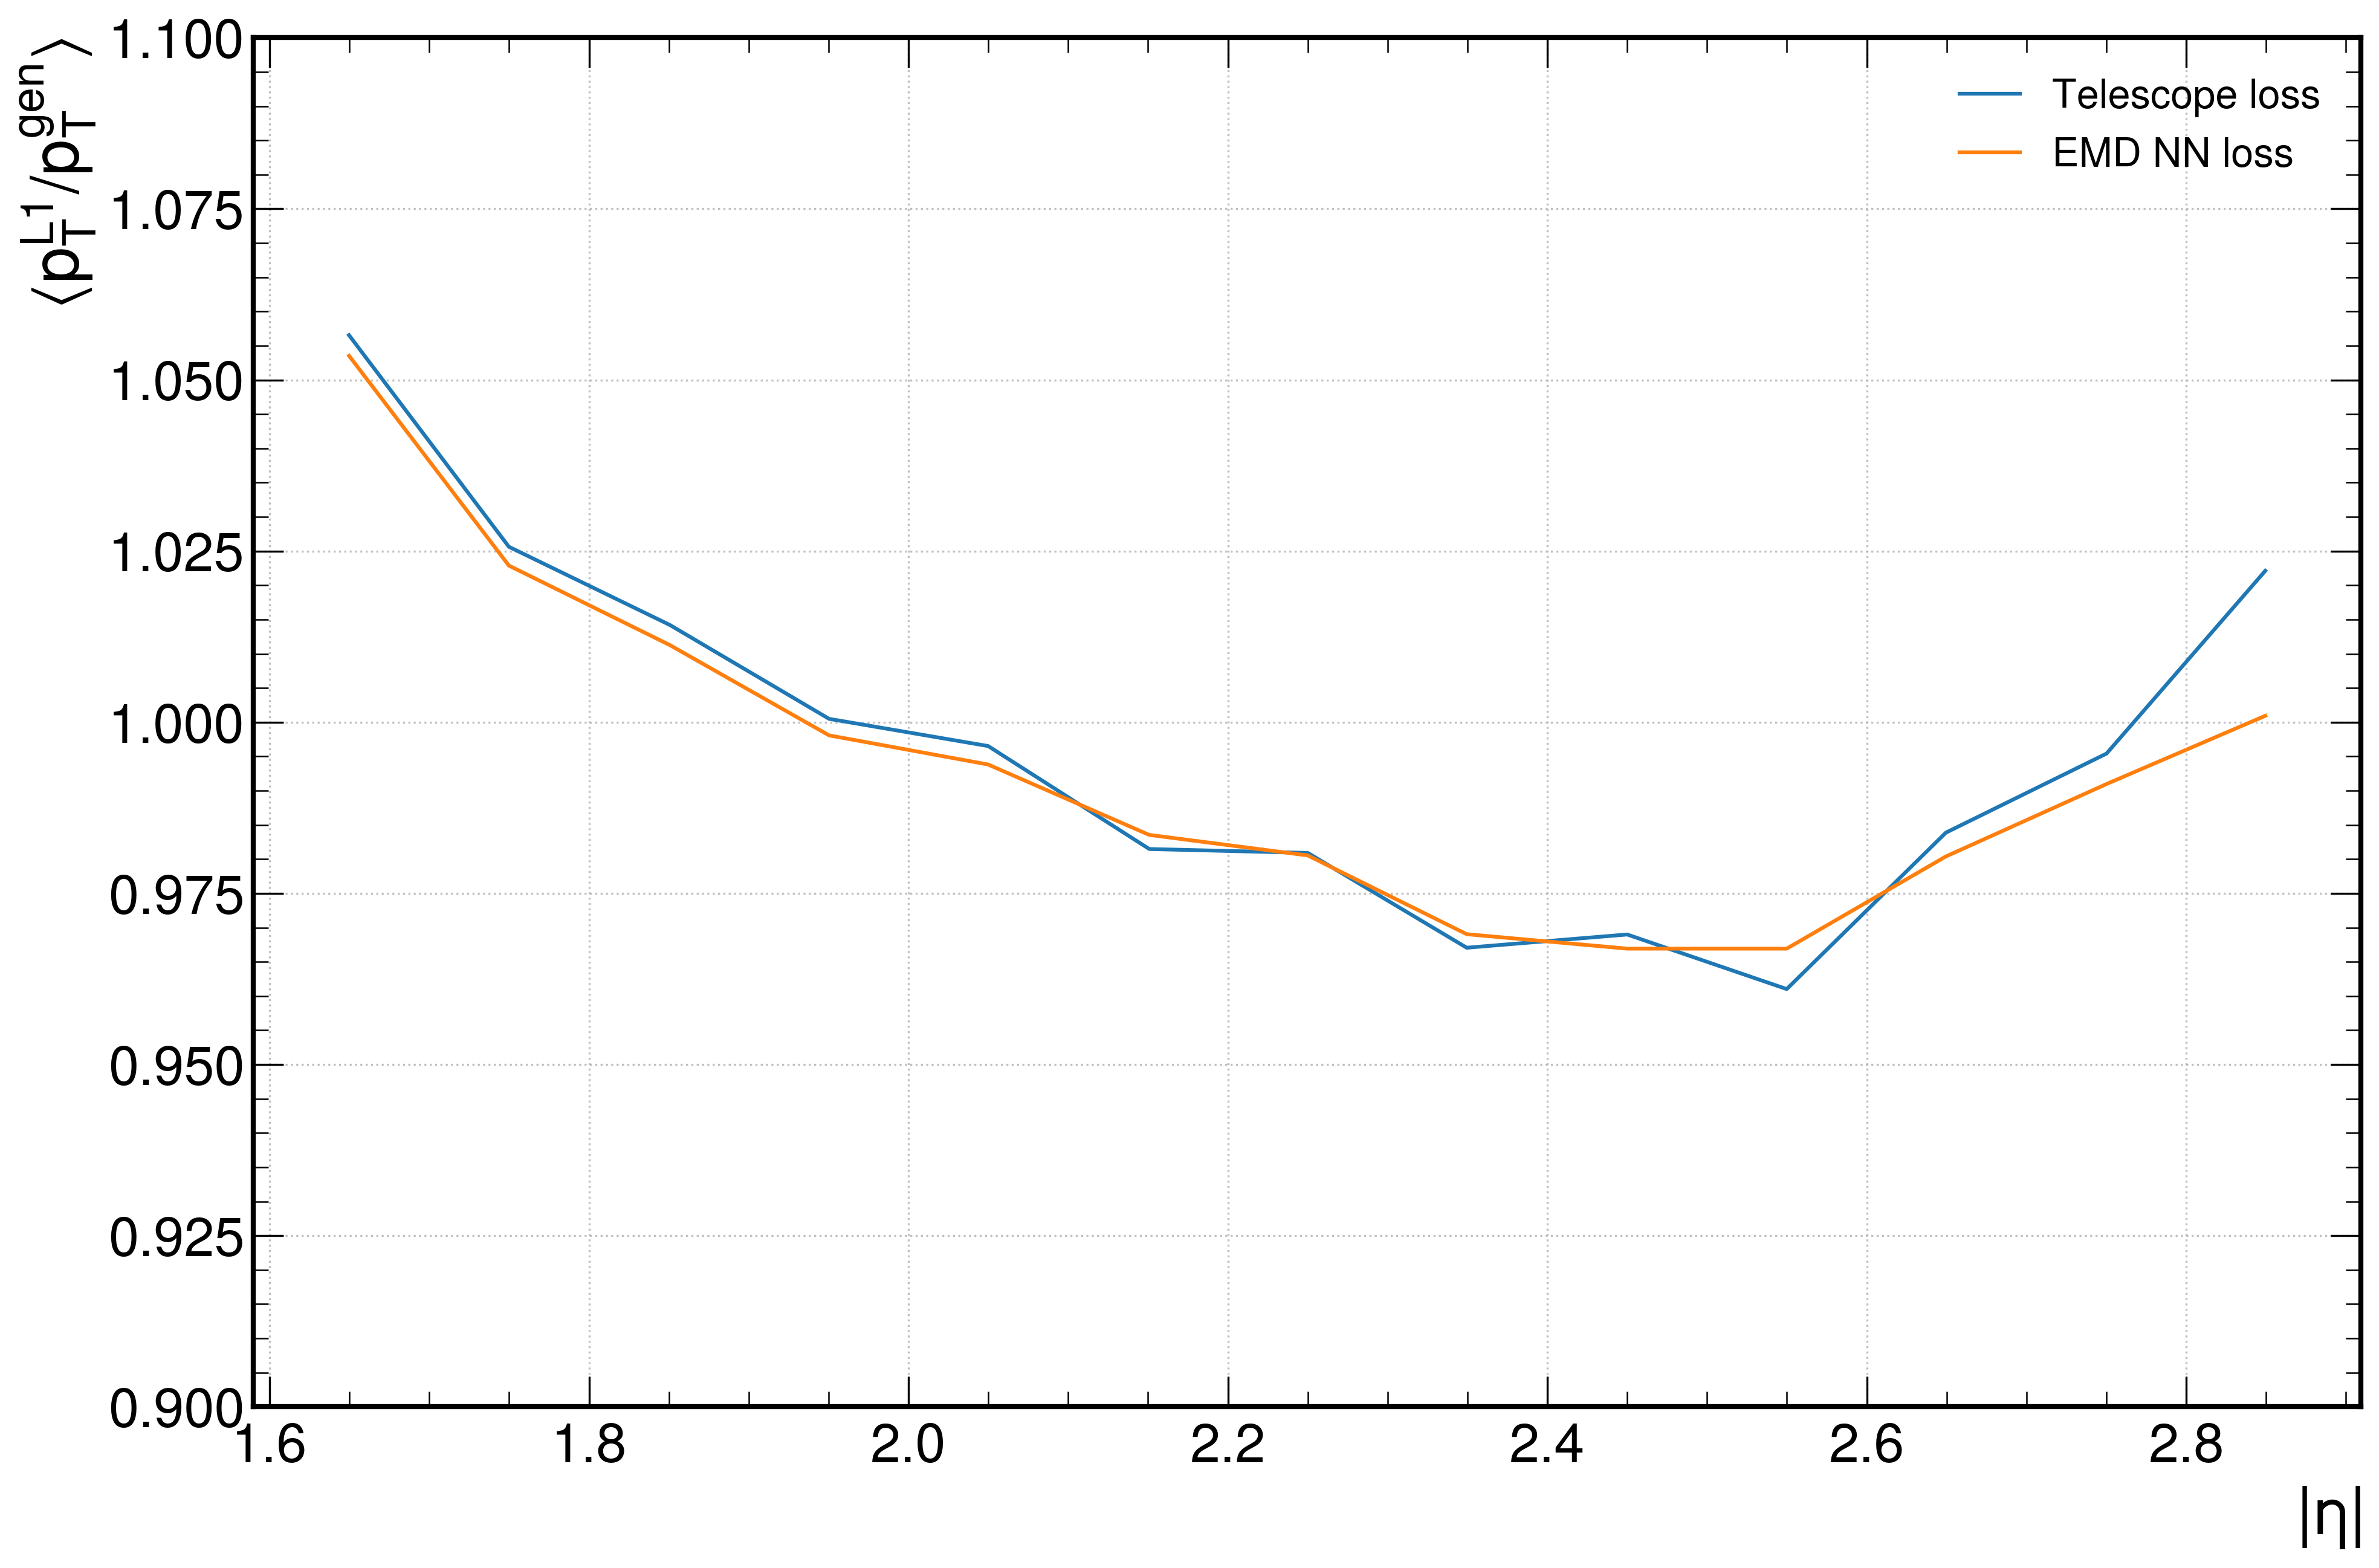

In [30]:
print('Mean vs eta')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = etameans[name]
    plt.plot(df['genpart_abseta'], df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0.9, 1.1)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$|\eta|$')
plt.ylabel(r'$\langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid()
plt.savefig(fig_dir+'/mean_v_eta.png')
plt.show()

RMS vs eta


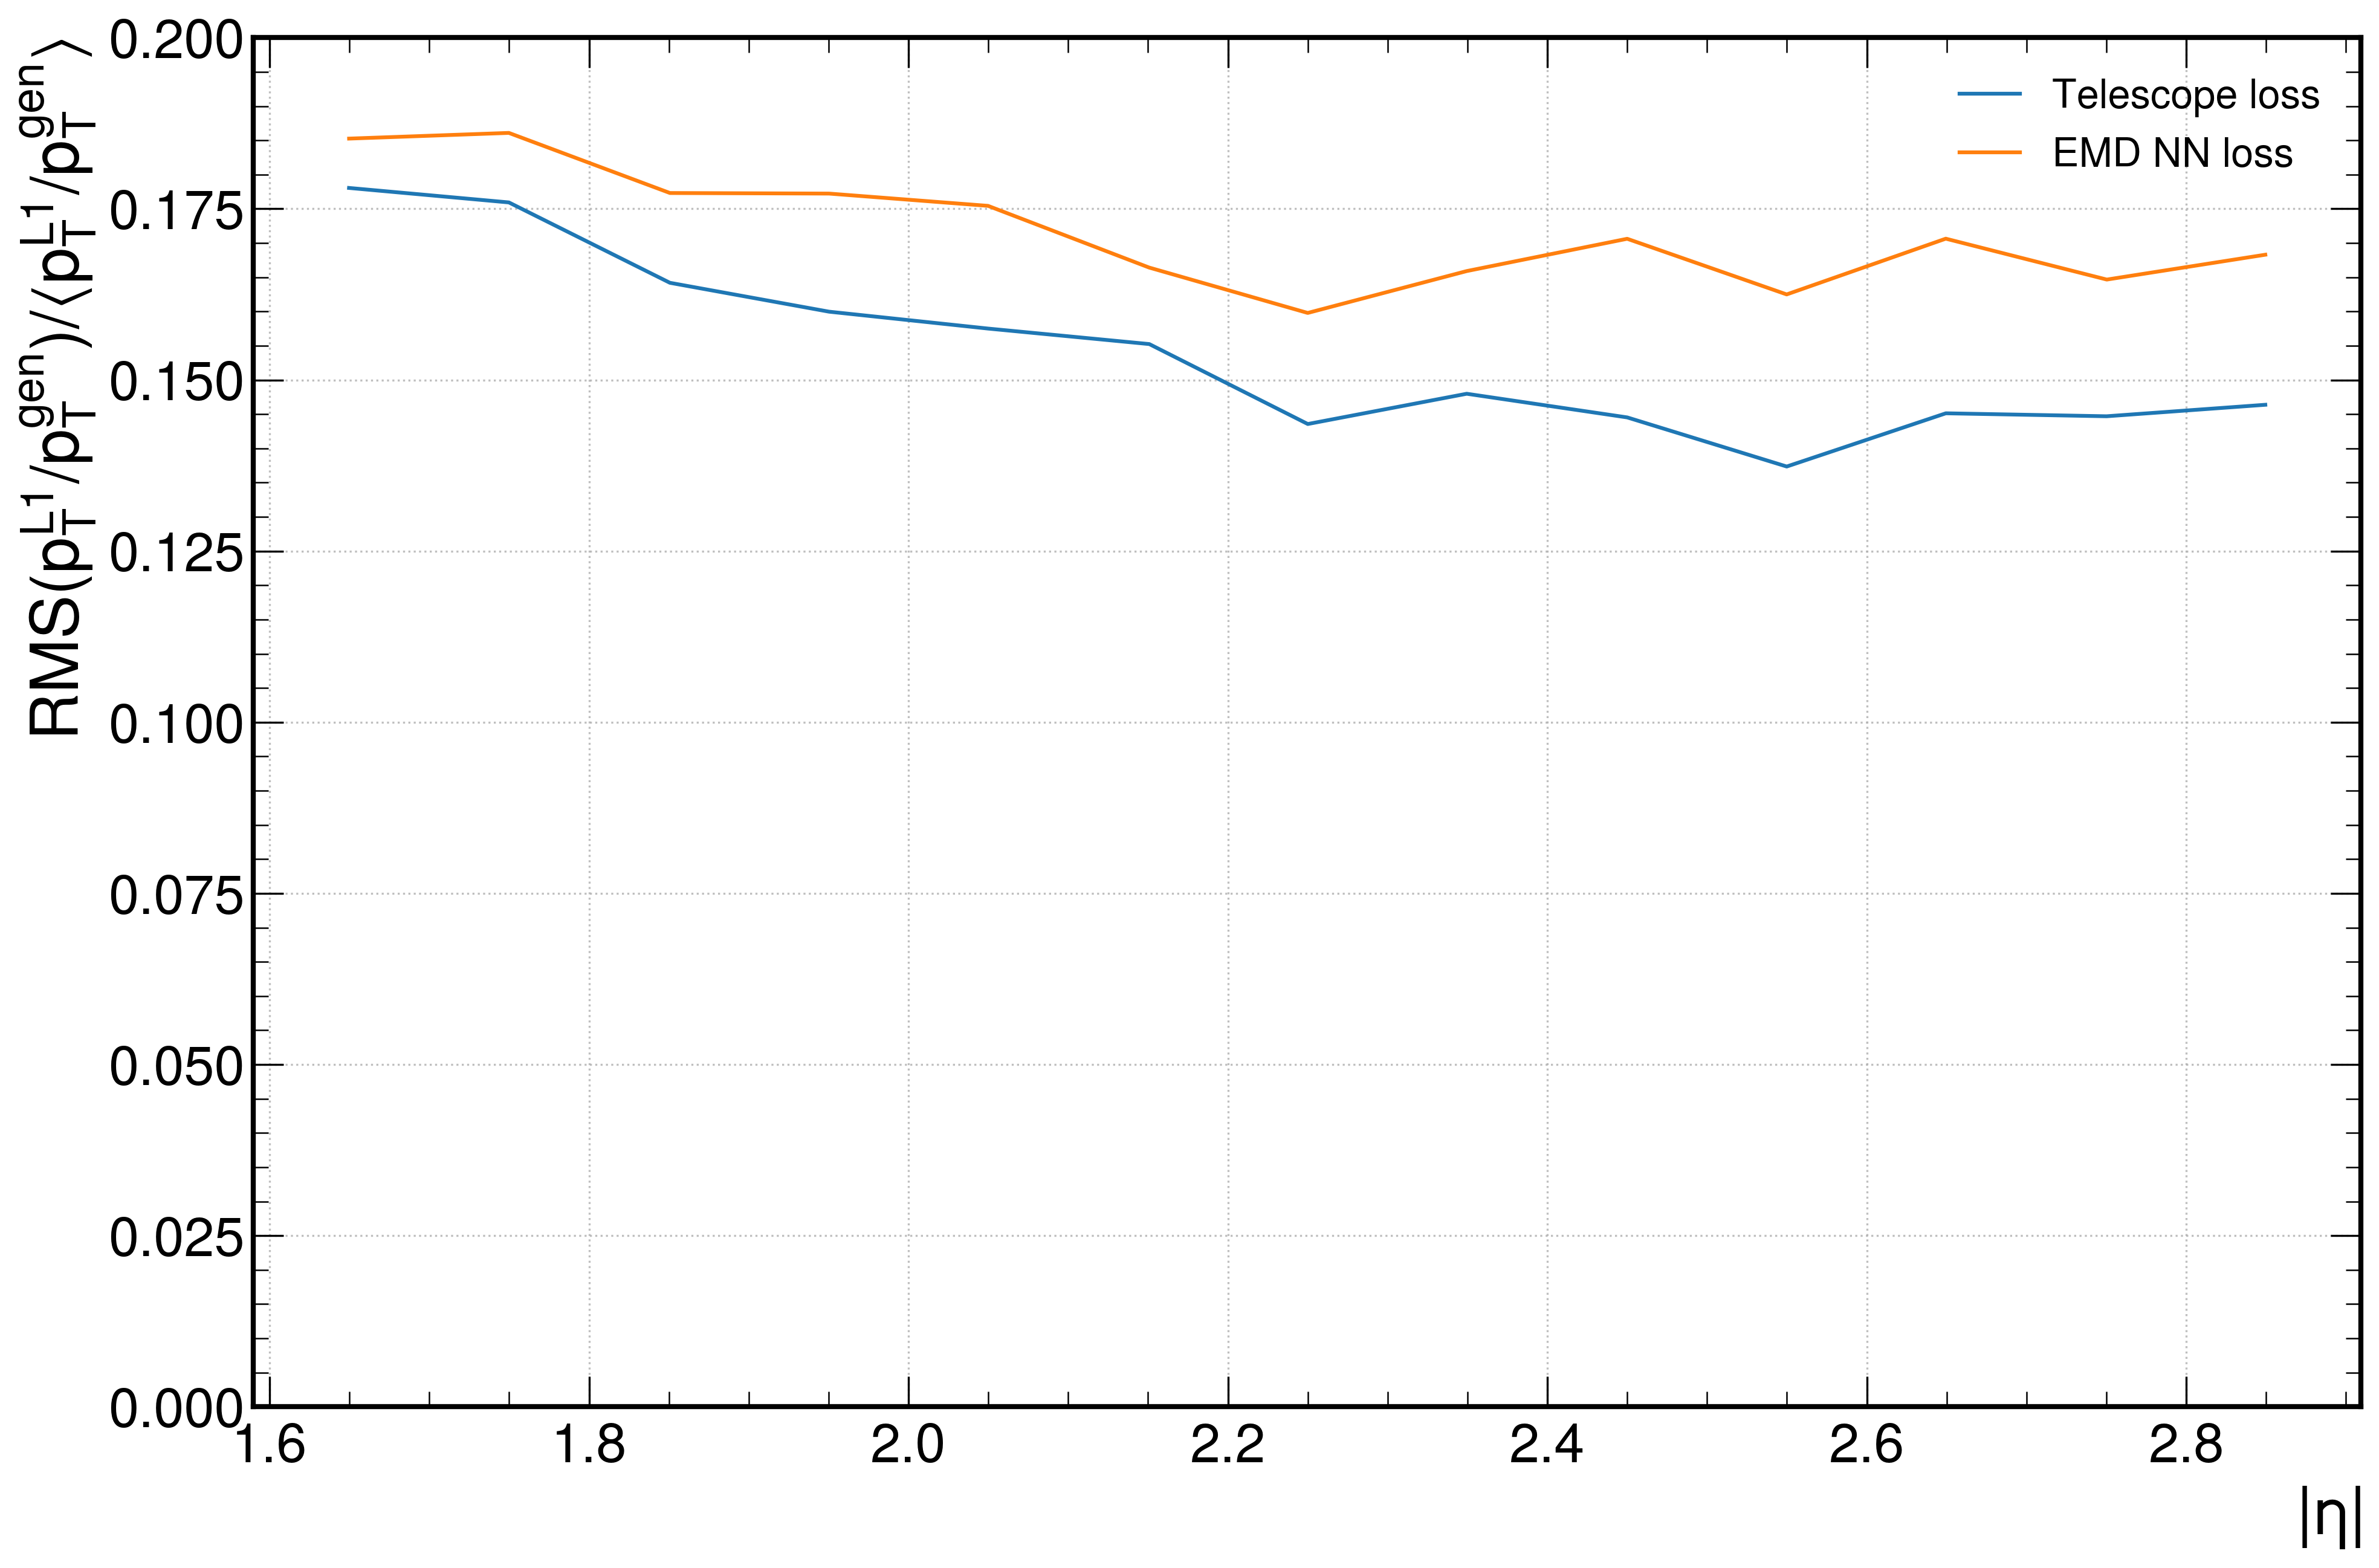

In [36]:
print('RMS vs eta')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = etameans[name]
    plt.plot(df['genpart_abseta'], etarmss[name]['corr_eta_over_gen_pt']/df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0., 0.2)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$|\eta|$')
plt.ylabel(r'$RMS(p_{T}^{L1}/p_{T}^{gen}) / \langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid()
plt.savefig(fig_dir+'/rms_v_eta.png')
plt.show()

Eff RMS vs eta


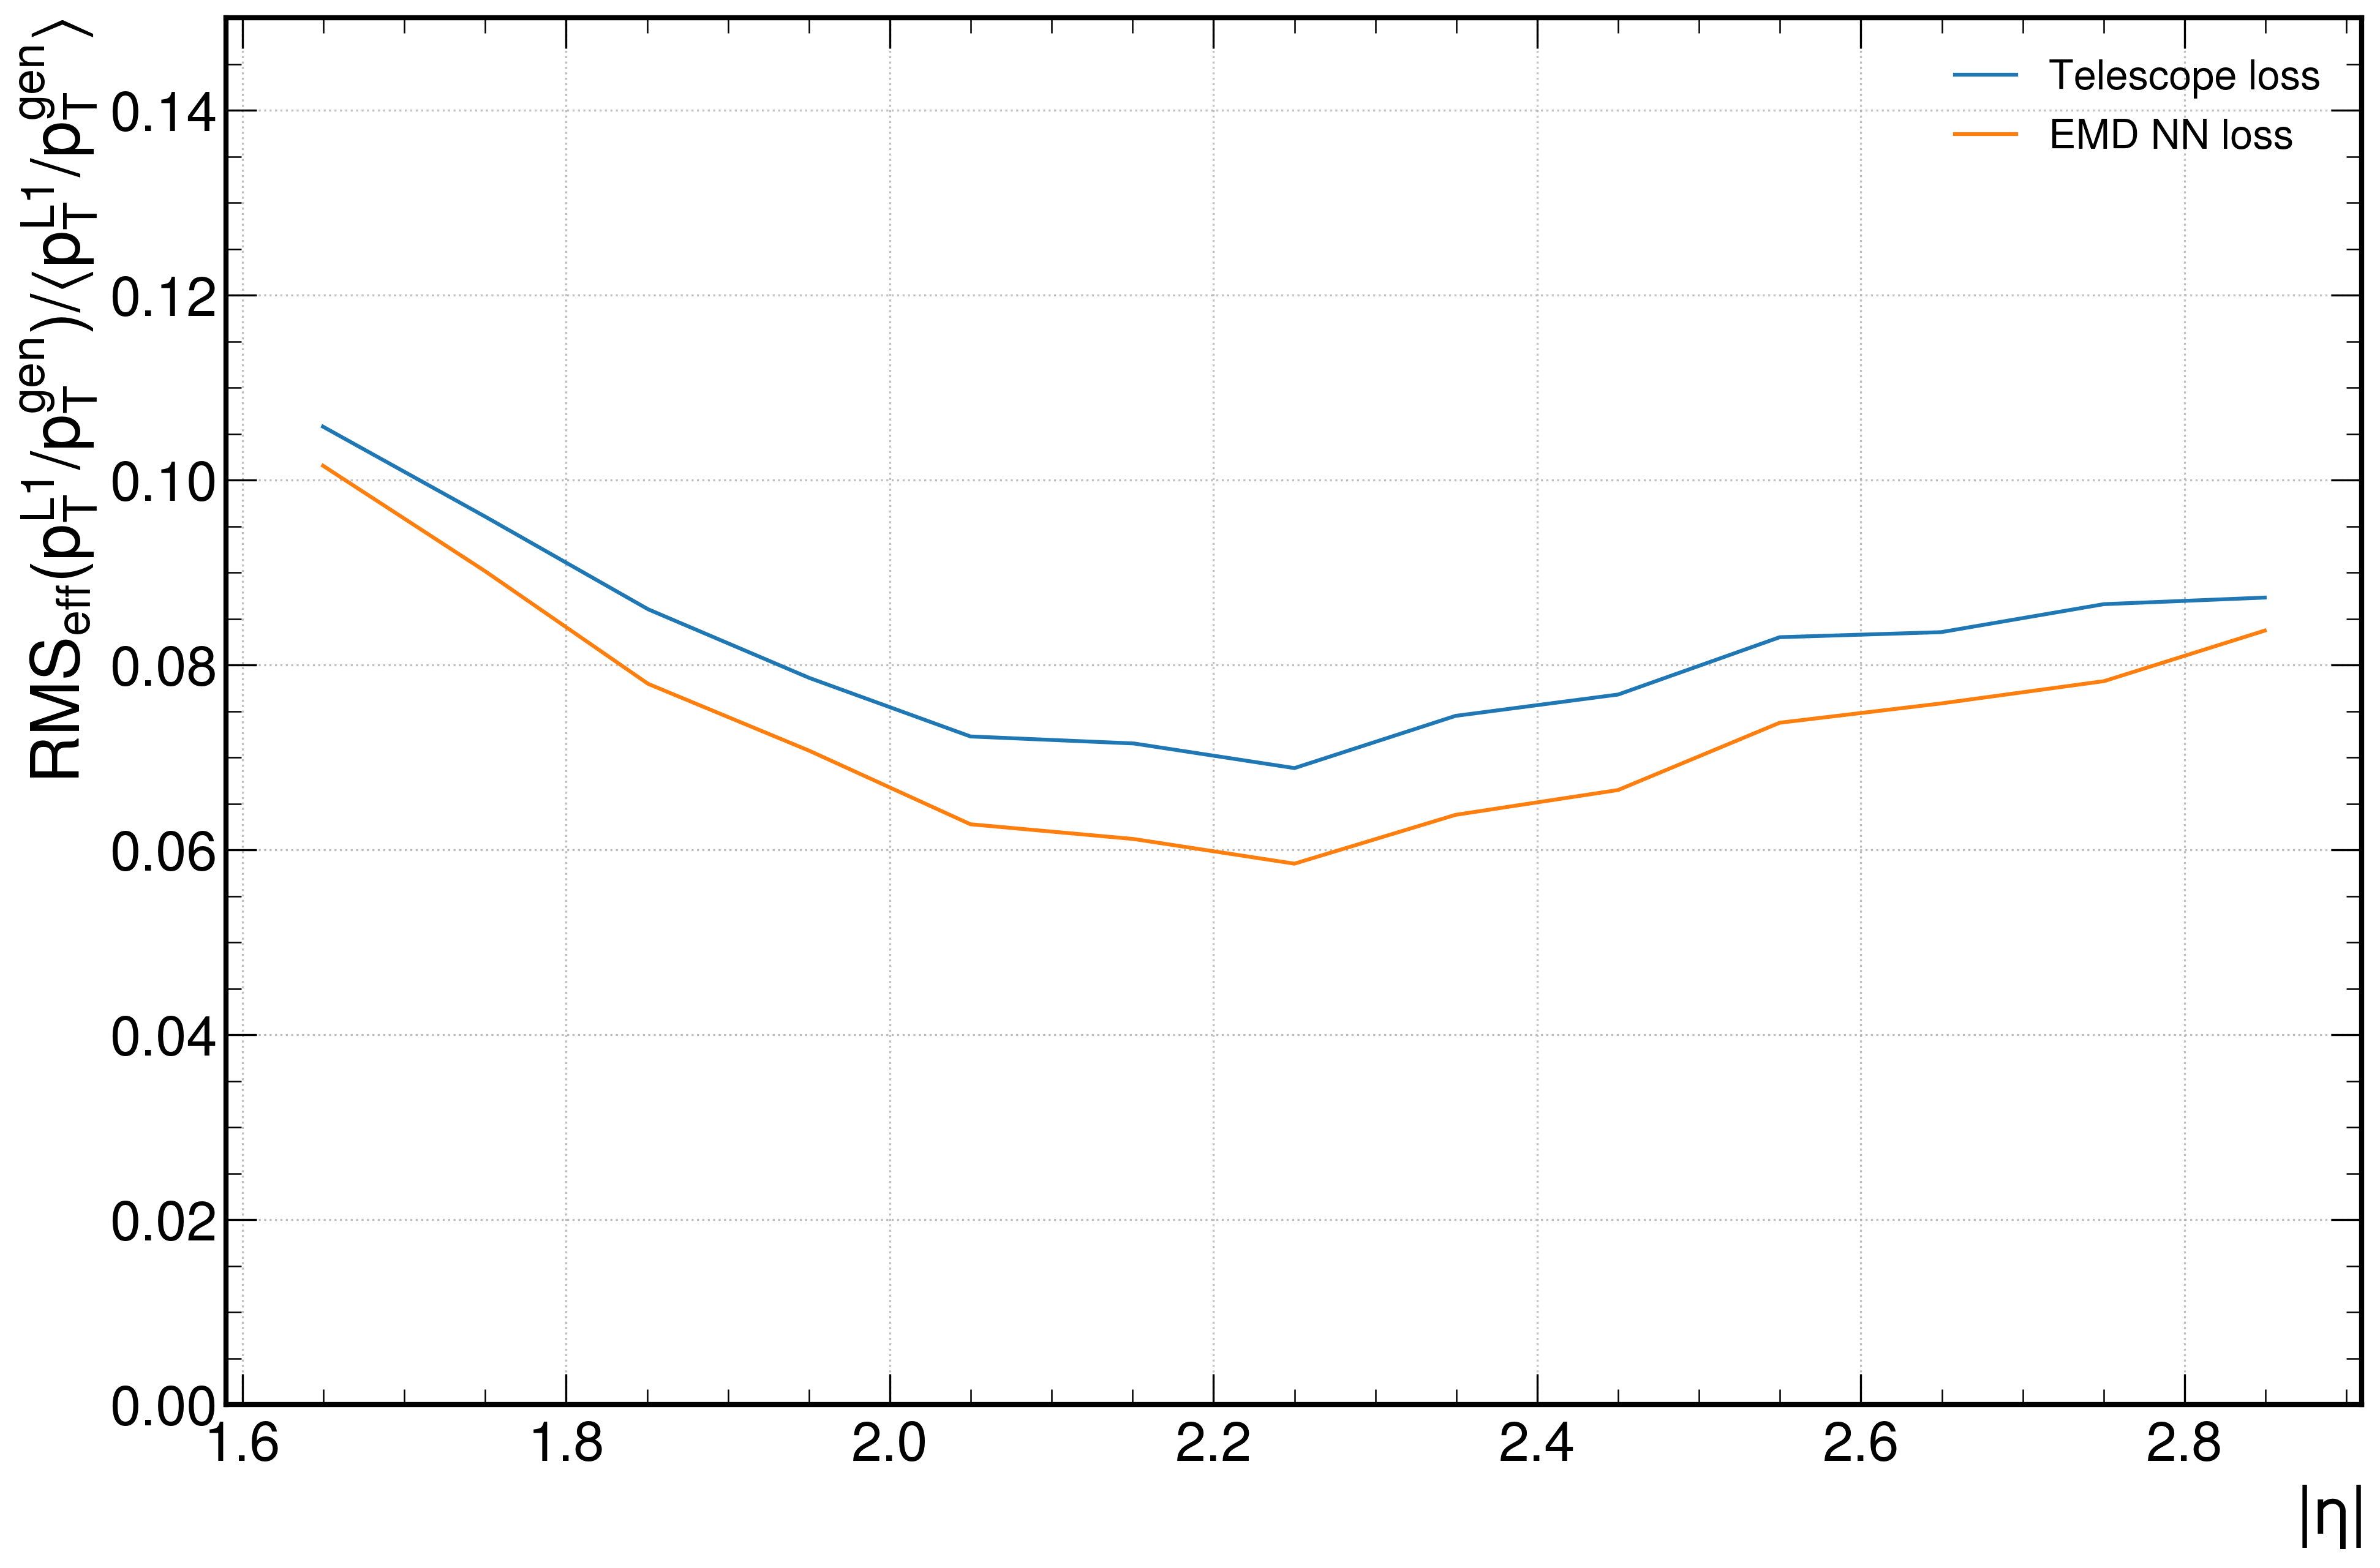

In [34]:
print('Eff RMS vs eta')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = etameans[name]
    plt.plot(df['genpart_abseta'], etaeffrmss[name]['corr_eta_over_gen_pt']/df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0., 0.15)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$|\eta|$')
plt.ylabel(r'$RMS_{eff}(p_{T}^{L1}/p_{T}^{gen}) / \langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid()
plt.savefig(fig_dir+'/rms_eff_v_eta.png')
plt.show()

Mean vs pt


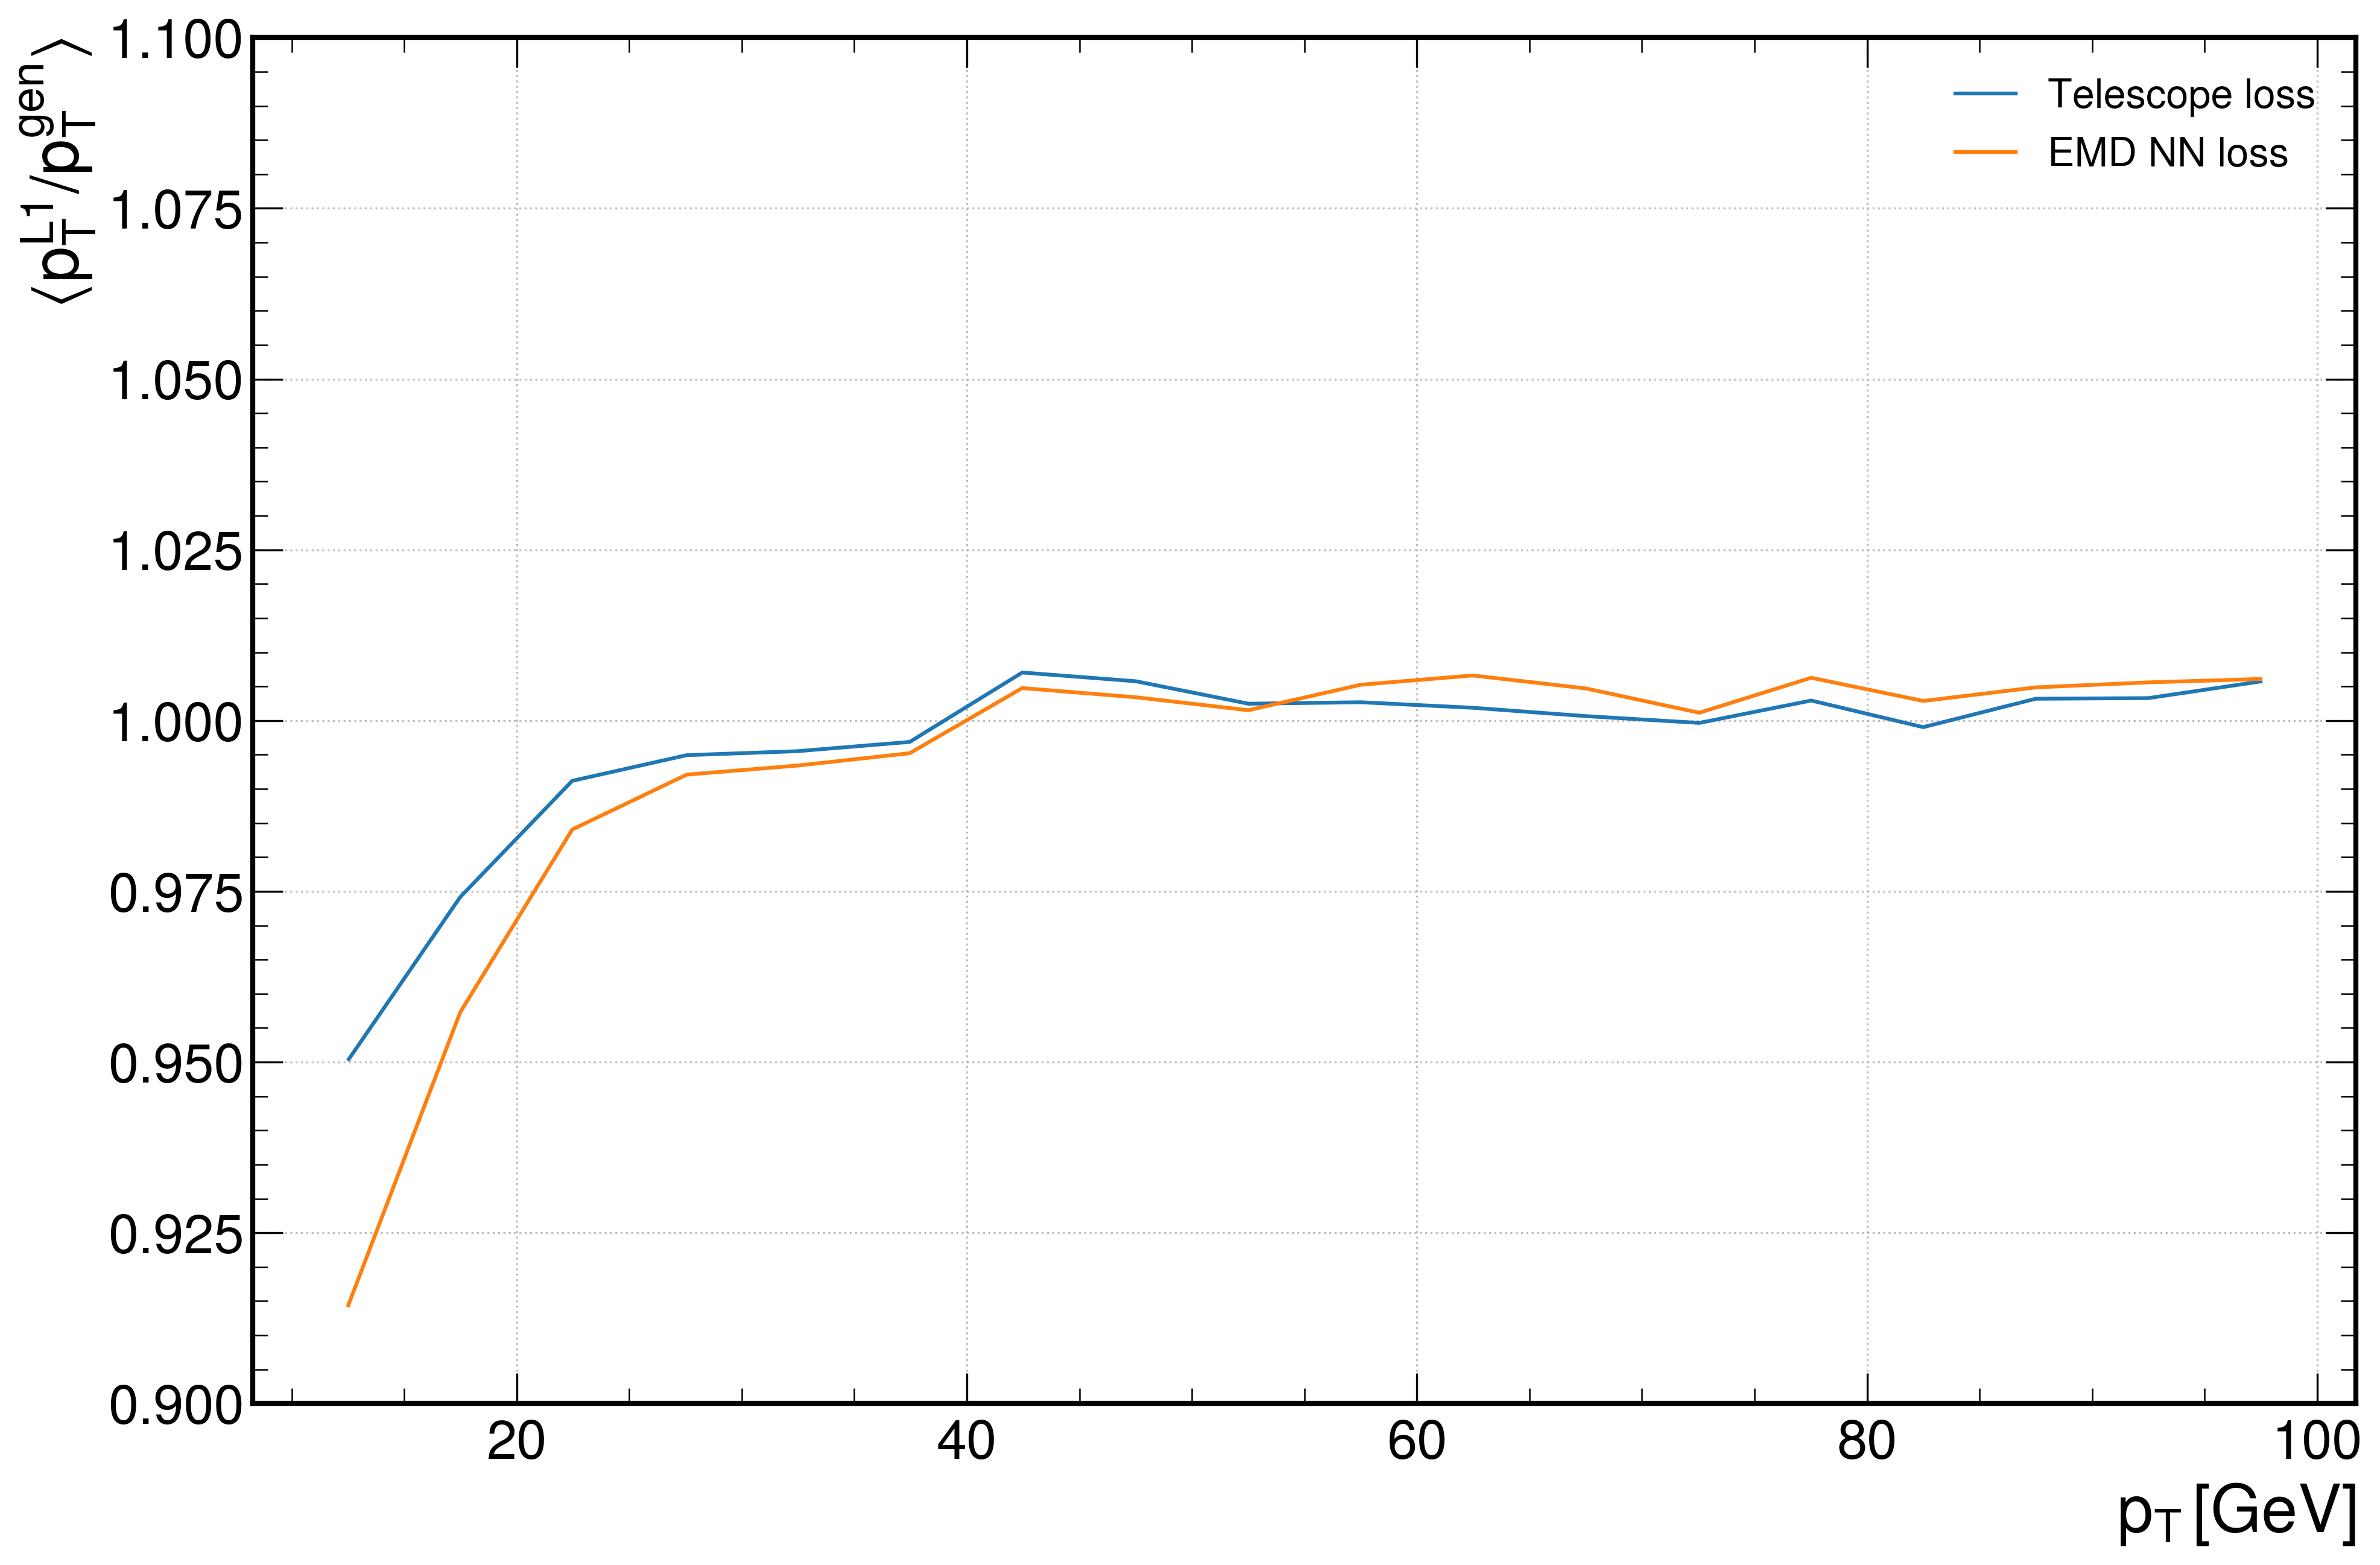

In [37]:
print('Mean vs pt')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = ptmeans[name]
    plt.plot(df['genpart_pt'], df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0.9, 1.1)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$p_{T}\, [GeV]$')
plt.ylabel(r'$\langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid()
plt.savefig(fig_dir+'/rms_eff_v_eta.png')
plt.show()

RMS vs pt


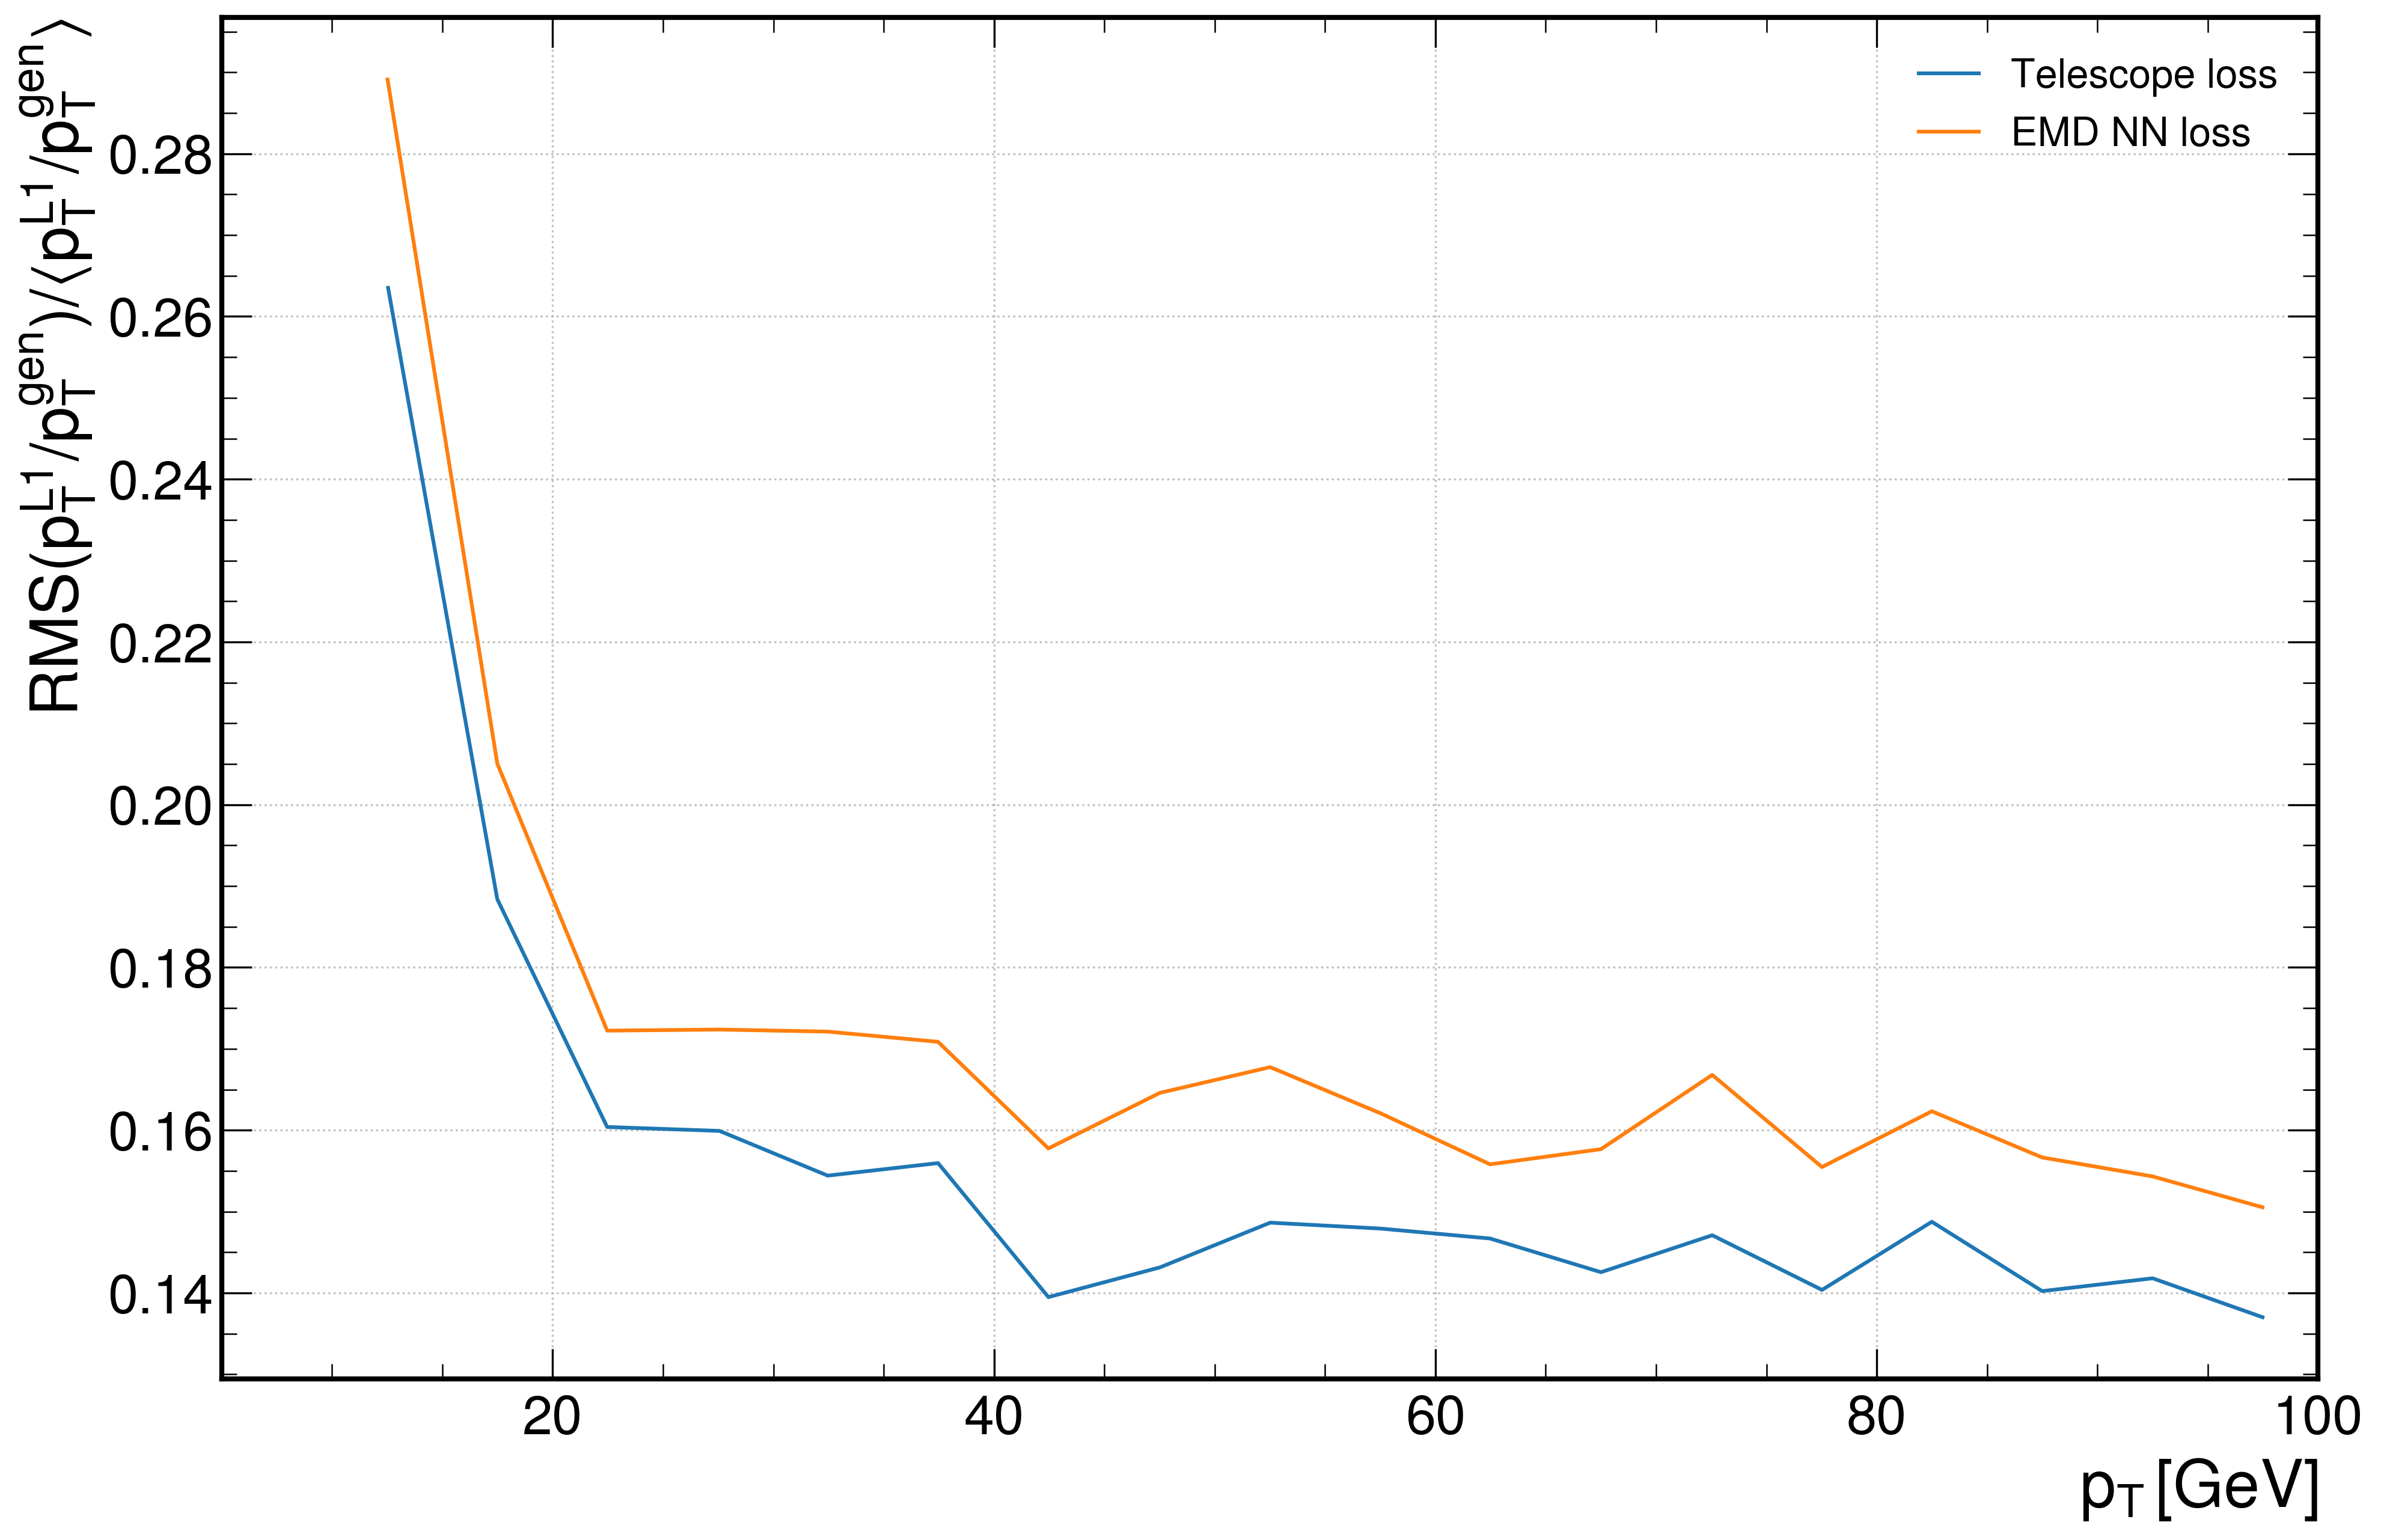

In [39]:
print('RMS vs pt')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = ptmeans[name]
    plt.plot(df['genpart_pt'], ptrmss[name]['corr_eta_over_gen_pt']/df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
#plt.ylim(0., 0.2)
plt.xlim(5., 100)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$p_{T}\, [GeV]$')
plt.ylabel(r'$RMS(p_{T}^{L1}/p_{T}^{gen}) / \langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid()
plt.savefig(fig_dir+'/mean_v_pT.png')
plt.show()

Eff RMS vs pt


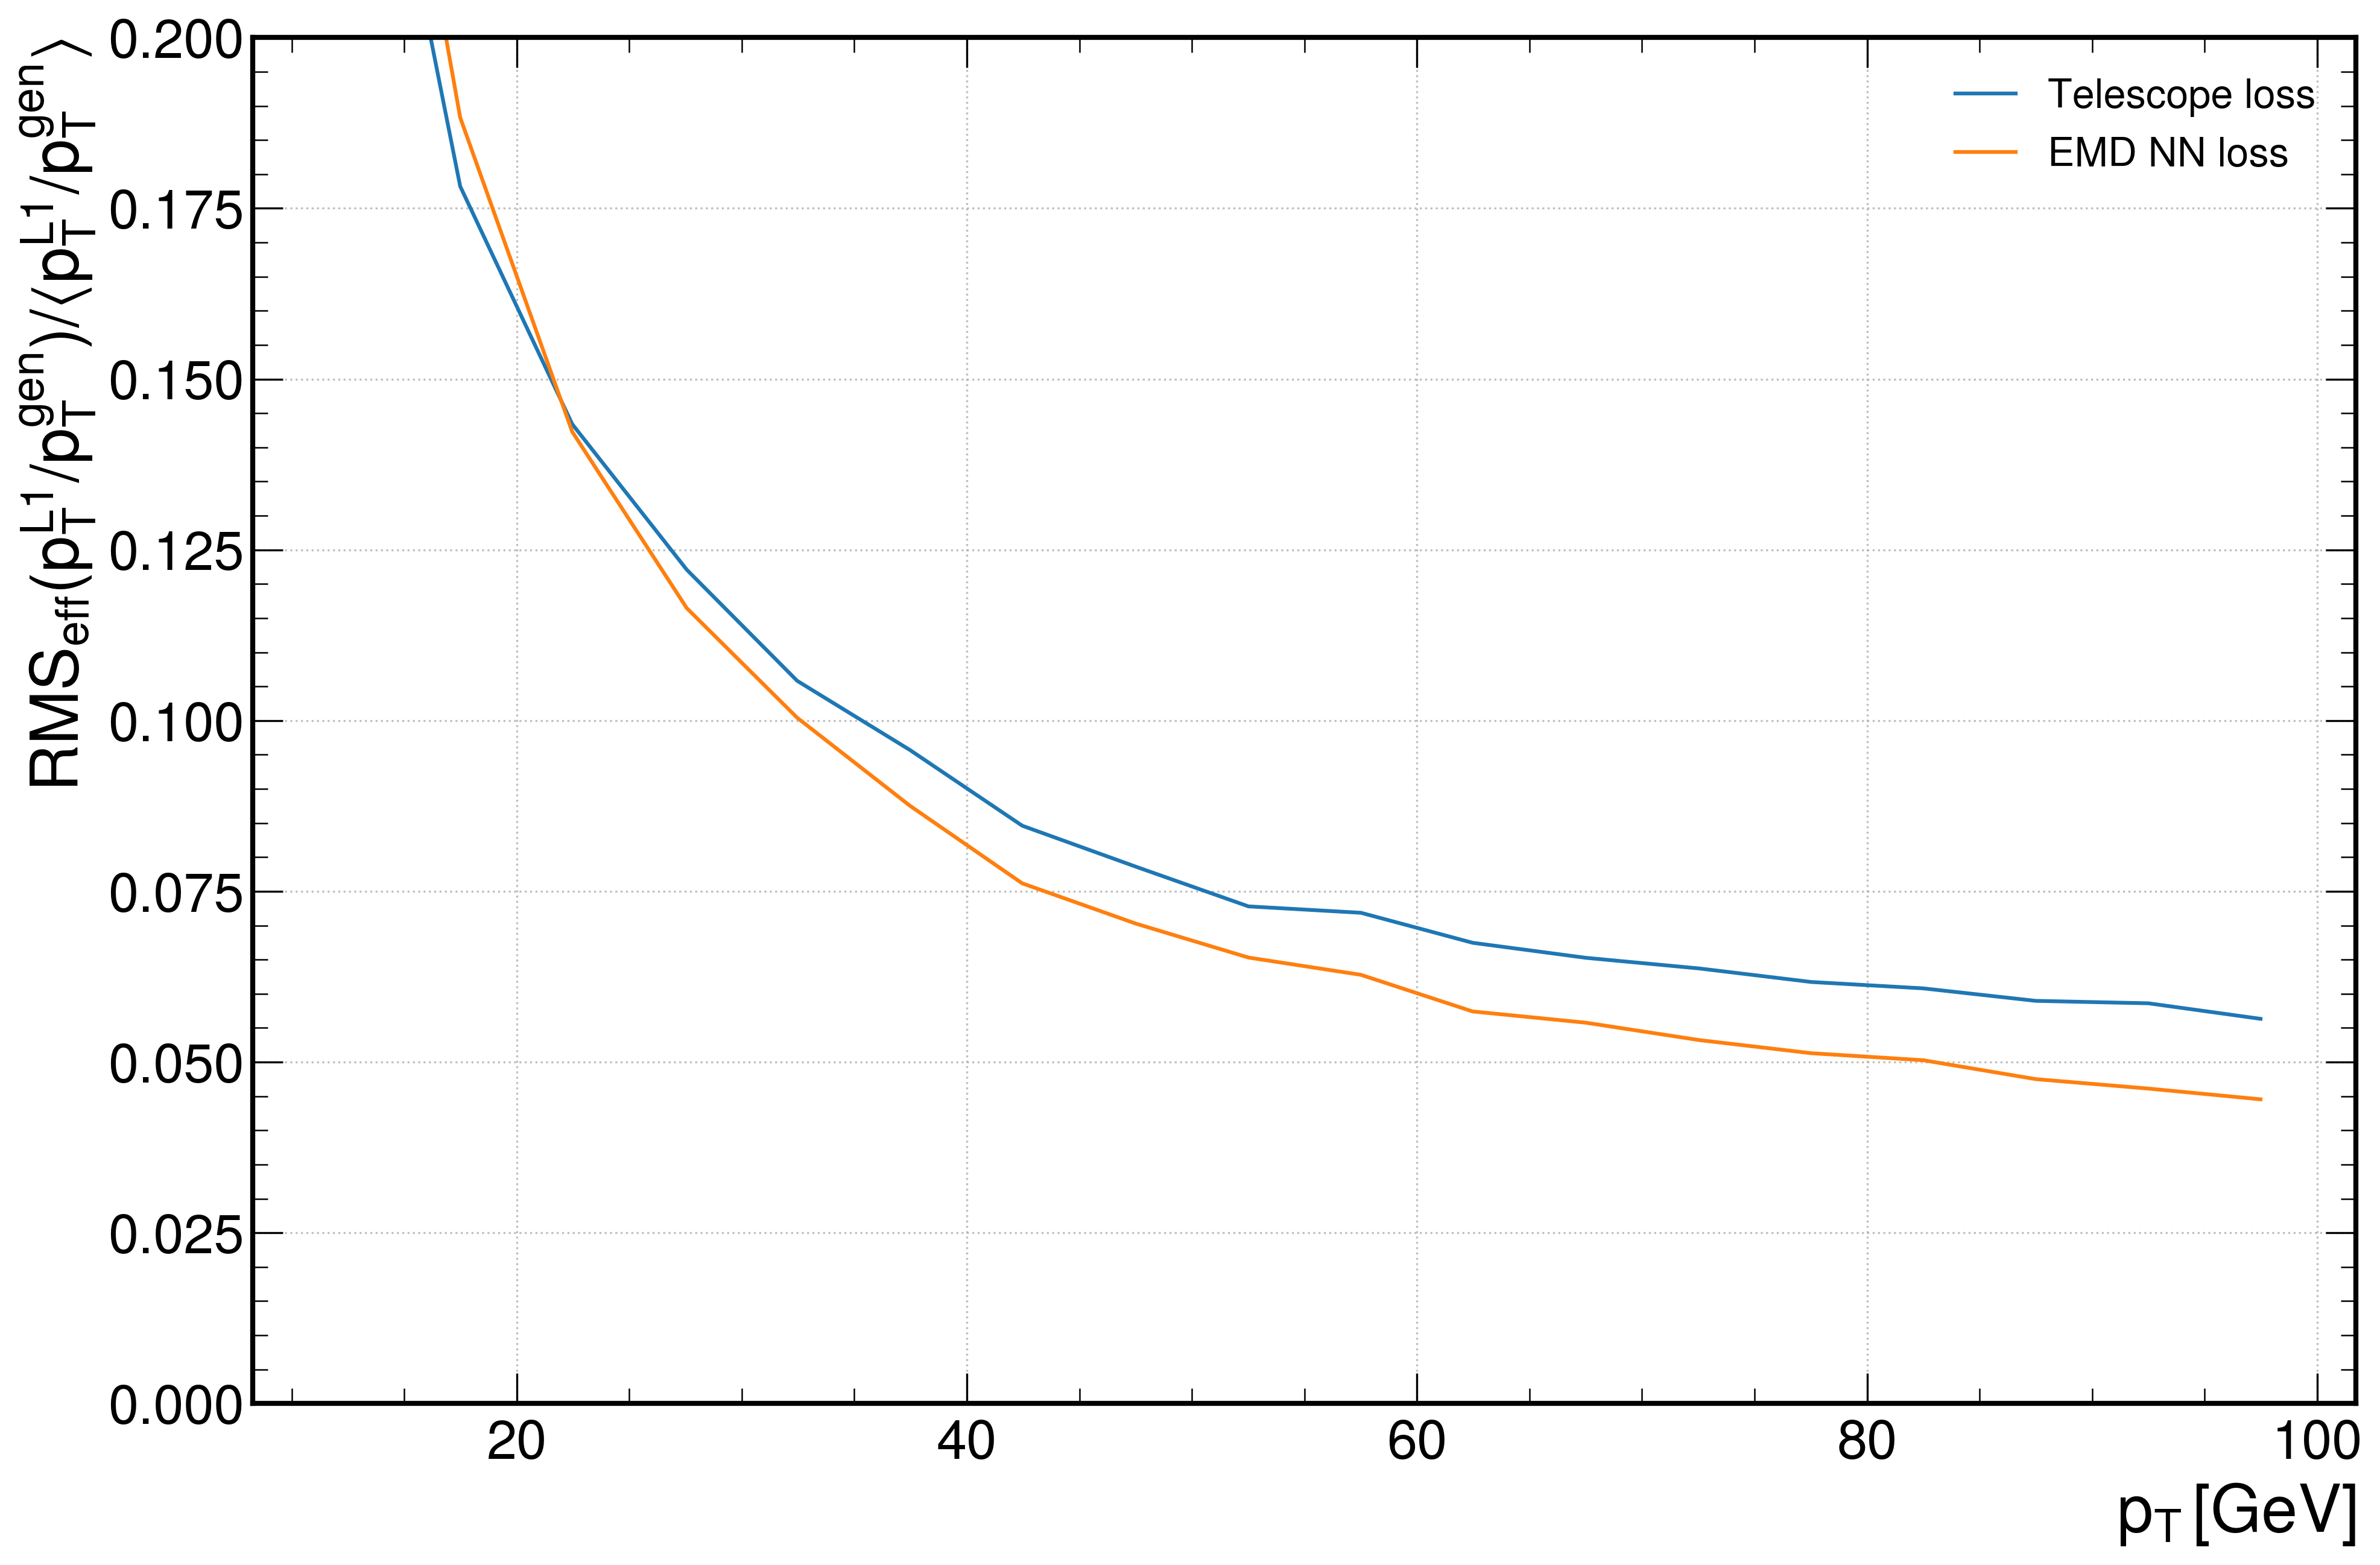

In [40]:
print('Eff RMS vs pt')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = ptmeans[name]
    plt.plot(df['genpart_pt'], pteffrmss[name]['corr_eta_over_gen_pt']/df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0., 0.2)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$p_{T}\, [GeV]$')
plt.ylabel(r'$RMS_{eff}(p_{T}^{L1}/p_{T}^{gen}) / \langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid()
plt.savefig(fig_dir+'/rms_eff_v_pT.png')
plt.show()

In [41]:
#Visualize phase space and relative performance with heatmaps

In [42]:
DENOM=both_eff_rms['AEtele']['corr_eta_over_gen_pt']/both_means['AEtele']['corr_eta_over_gen_pt']

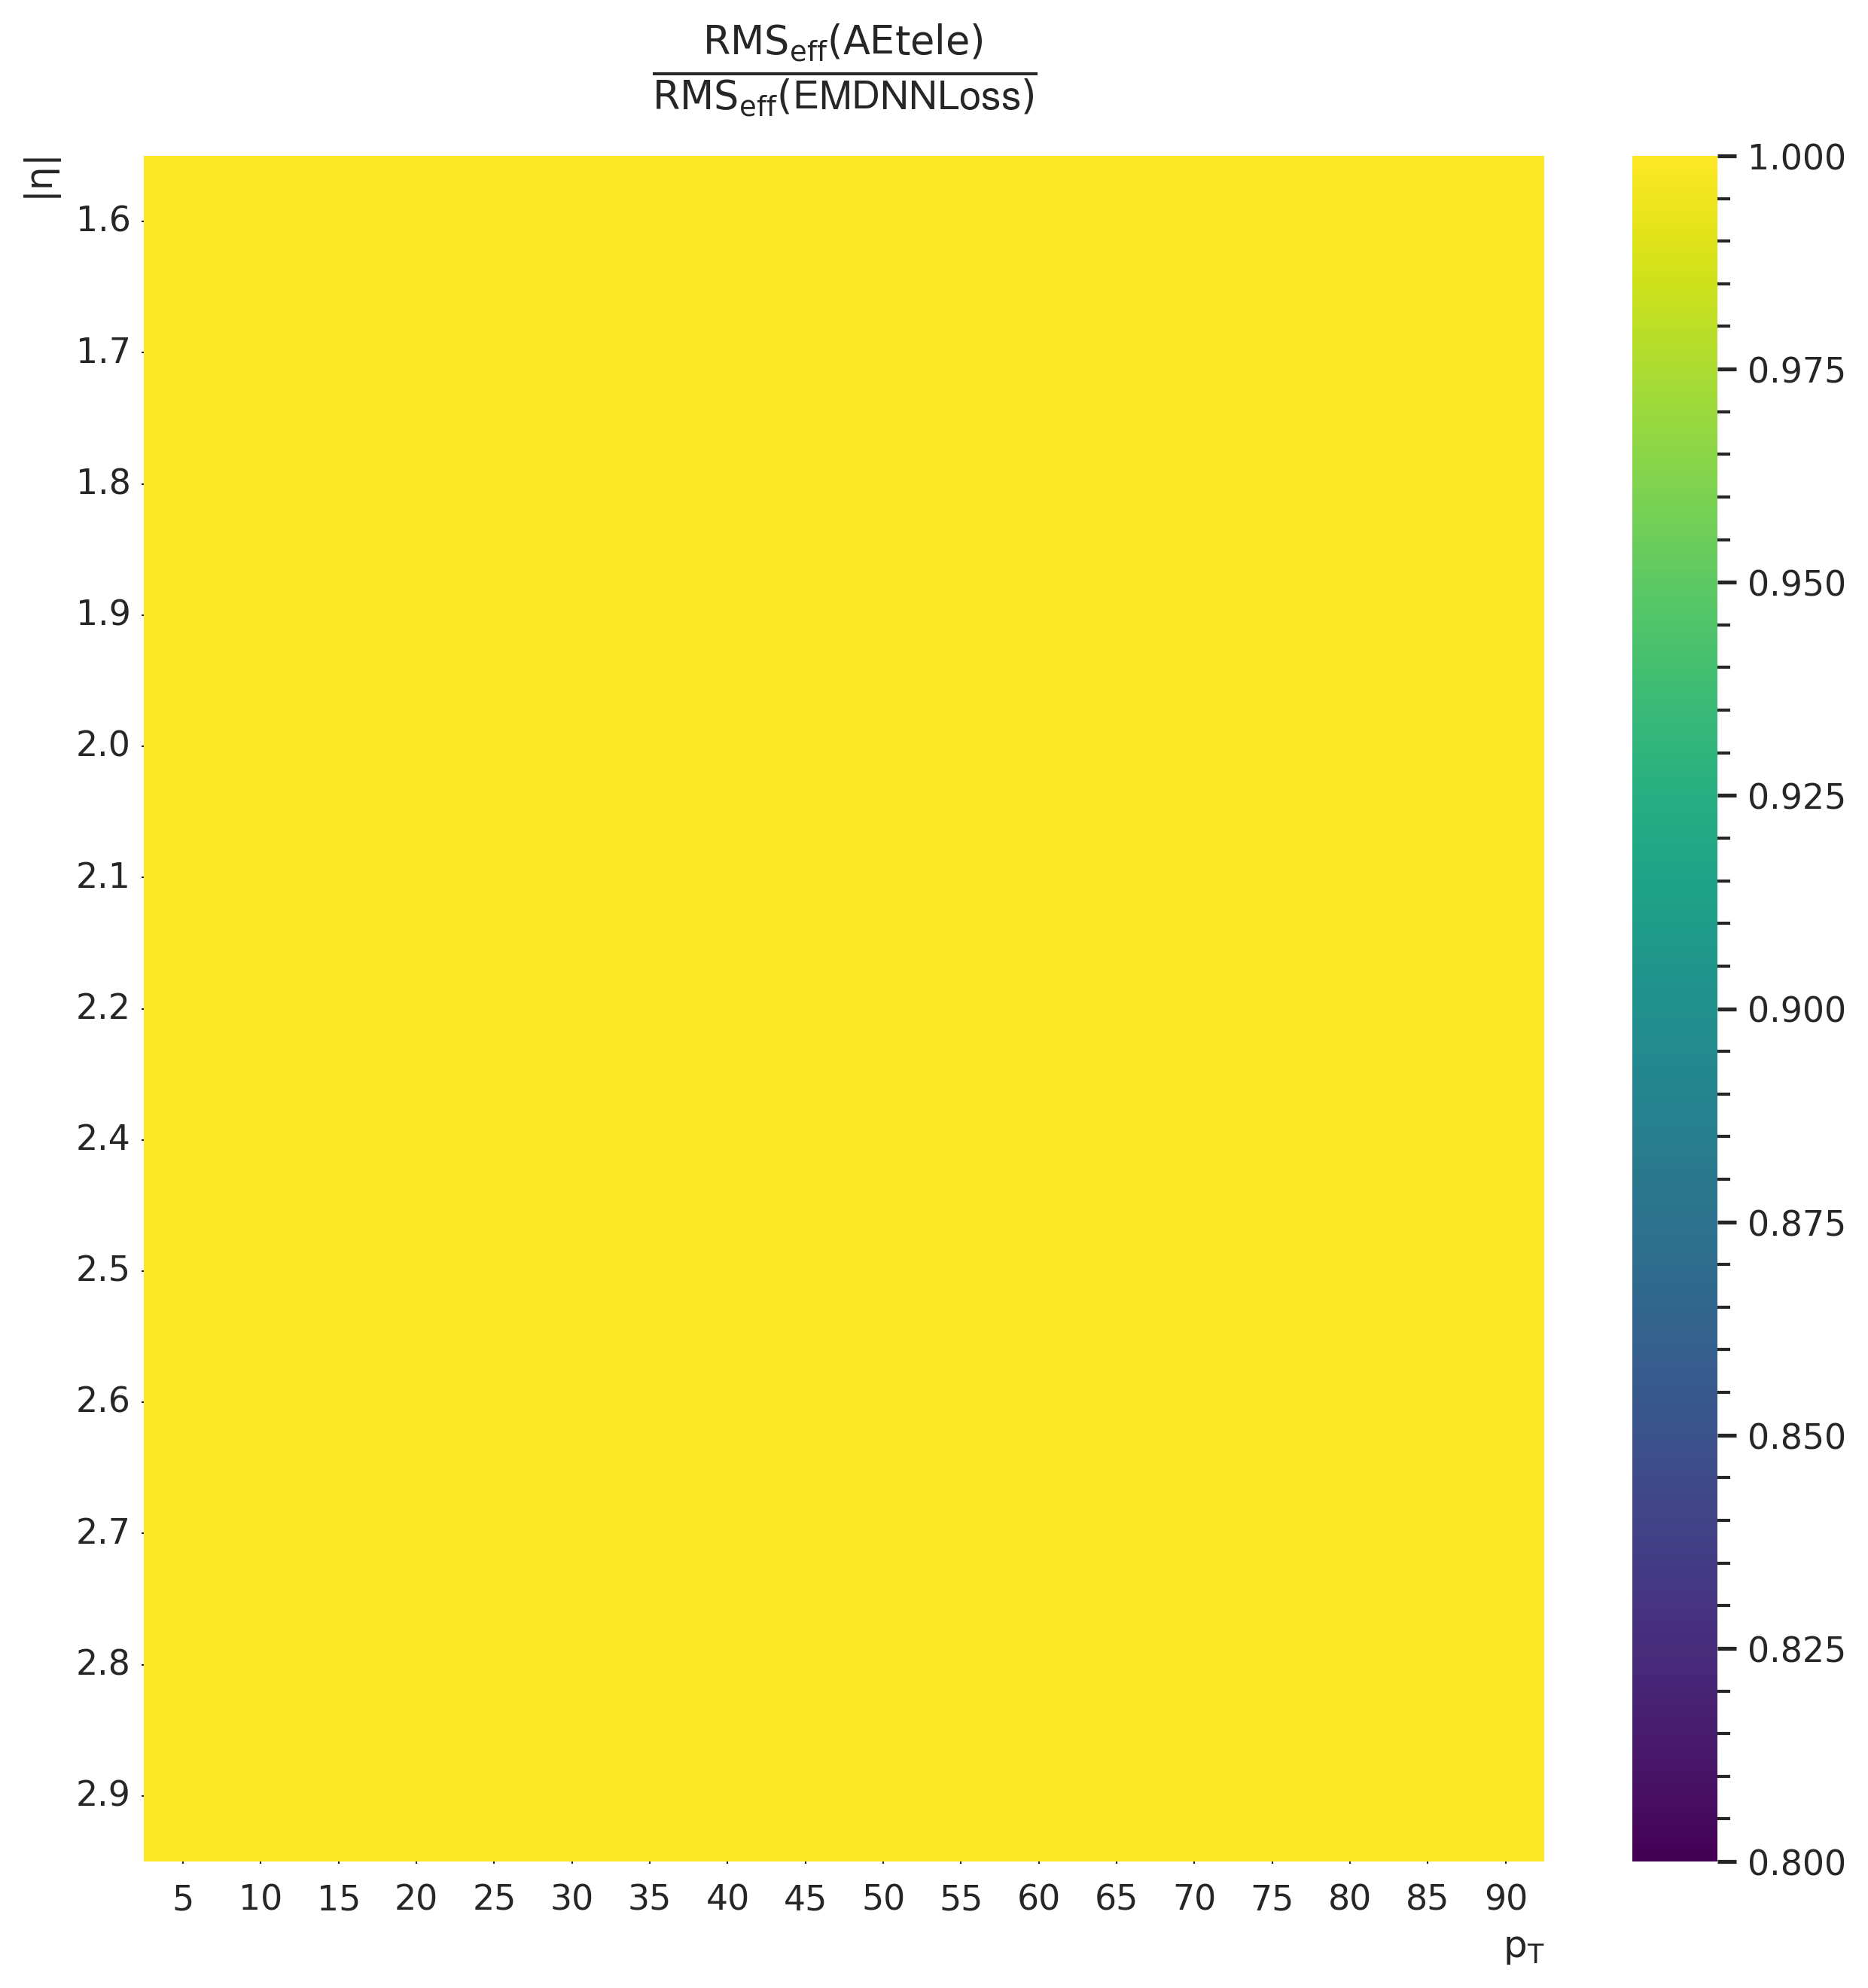

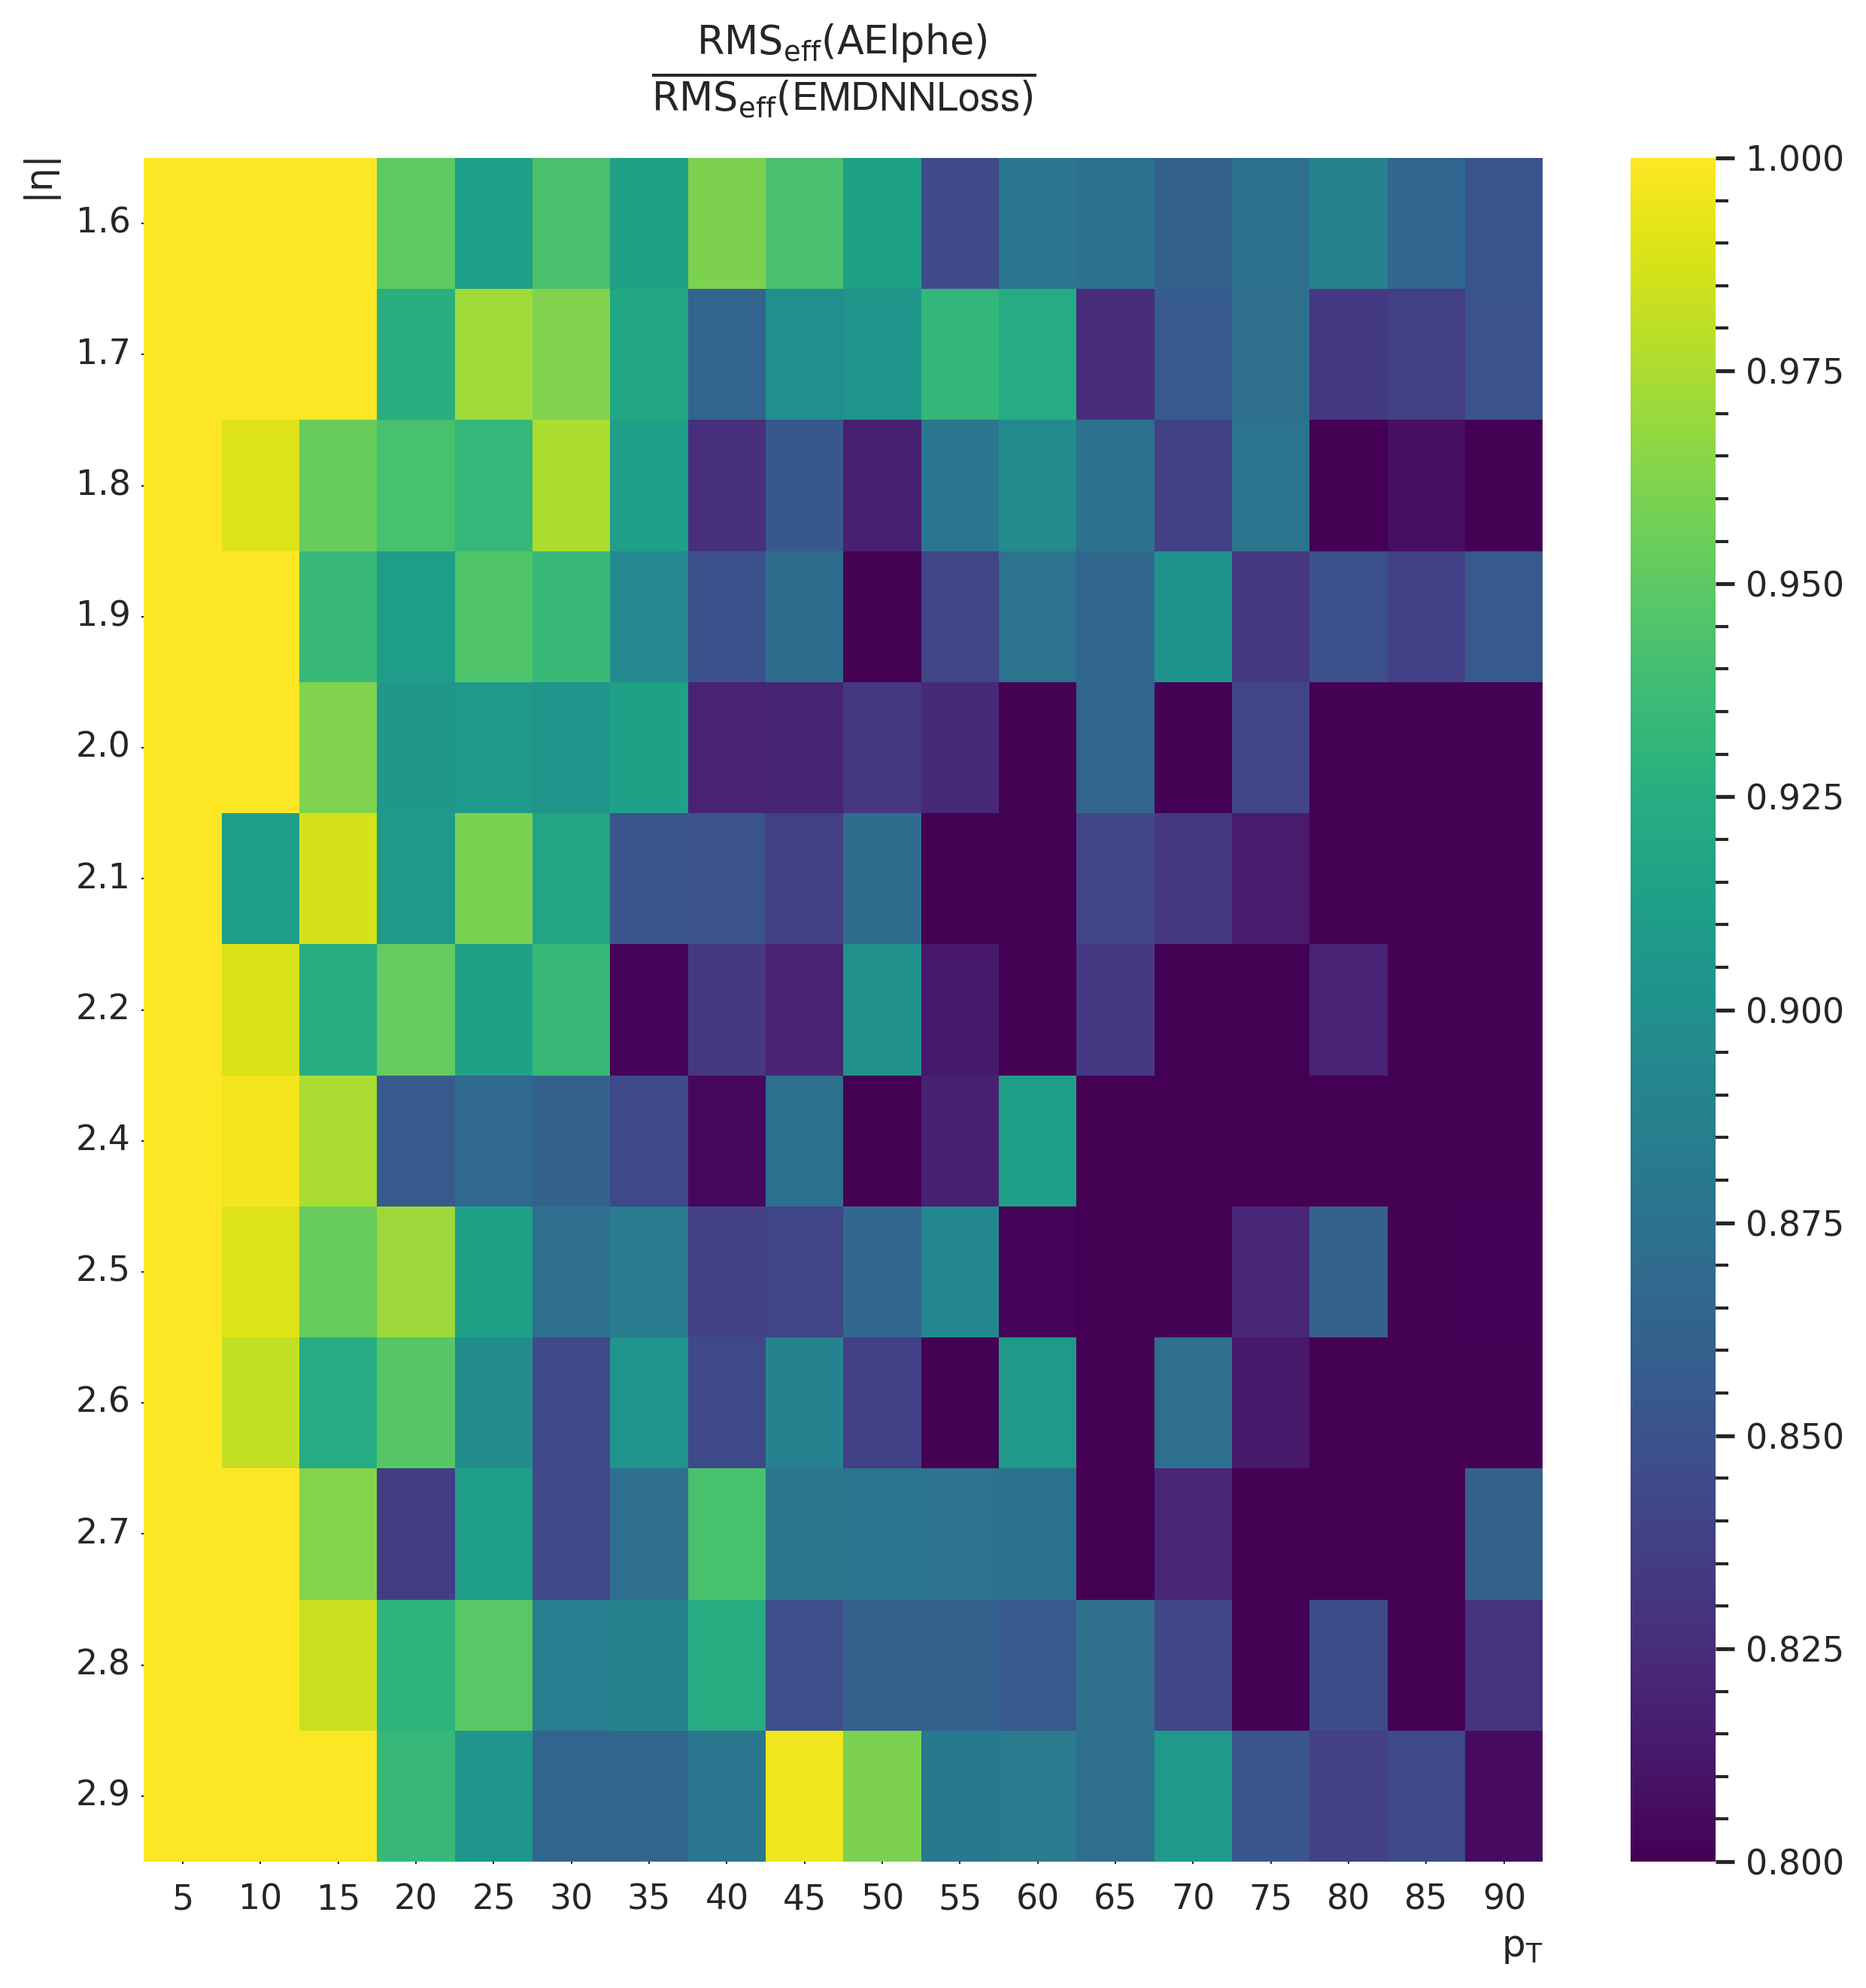

In [44]:
# calculate pt ratio and 68% CI
eta_bins = [f'{neta:0.1f}' for neta in np.linspace(etamin, etamax, 13)]
pt_bins = np.linspace(5, 90, 18).astype(int)

#Individual plots of the ones above: Ratio RMS_eff heatmaps
plt.close()
sns.set(font_scale=1.0)
for ix, (name, df_algo) in enumerate(algo_cut.items()):
    
    fig, axes = plt.subplots()    
    df = ((both_eff_rms[name]['corr_eta_over_gen_pt']/both_means[name]['corr_eta_over_gen_pt'])/DENOM)
    df = df.reset_index().pivot(columns='genpart_binpt', index='genpart_bineta')
    axes.tick_params(left=True,bottom=True, width =0.5,length=0.8)
    sns.heatmap(df, cmap = 'viridis',
                yticklabels=eta_bins,
                xticklabels = pt_bins,
                vmin=0.8, 
                vmax=1,
                #cbar=bool(ix%2)
               )
    #plt.title(legends[name])
    plt.xlabel(r'$p_{T}$')
    plt.ylabel('$|\eta|$')
    plt.yticks(rotation=0)
    plt.xticks(rotation=0)

    plt.title(r'$\frac{RMS_{eff}('+name+')}{RMS_{eff}(\mathrm{EMD NN Loss})}$',fontsize=18,y=1.03)
    plt.savefig(fig_dir+'/ratio_rms_eff_pt_eta'+name+'.png',dpi=300)
    plt.show()
    df={}

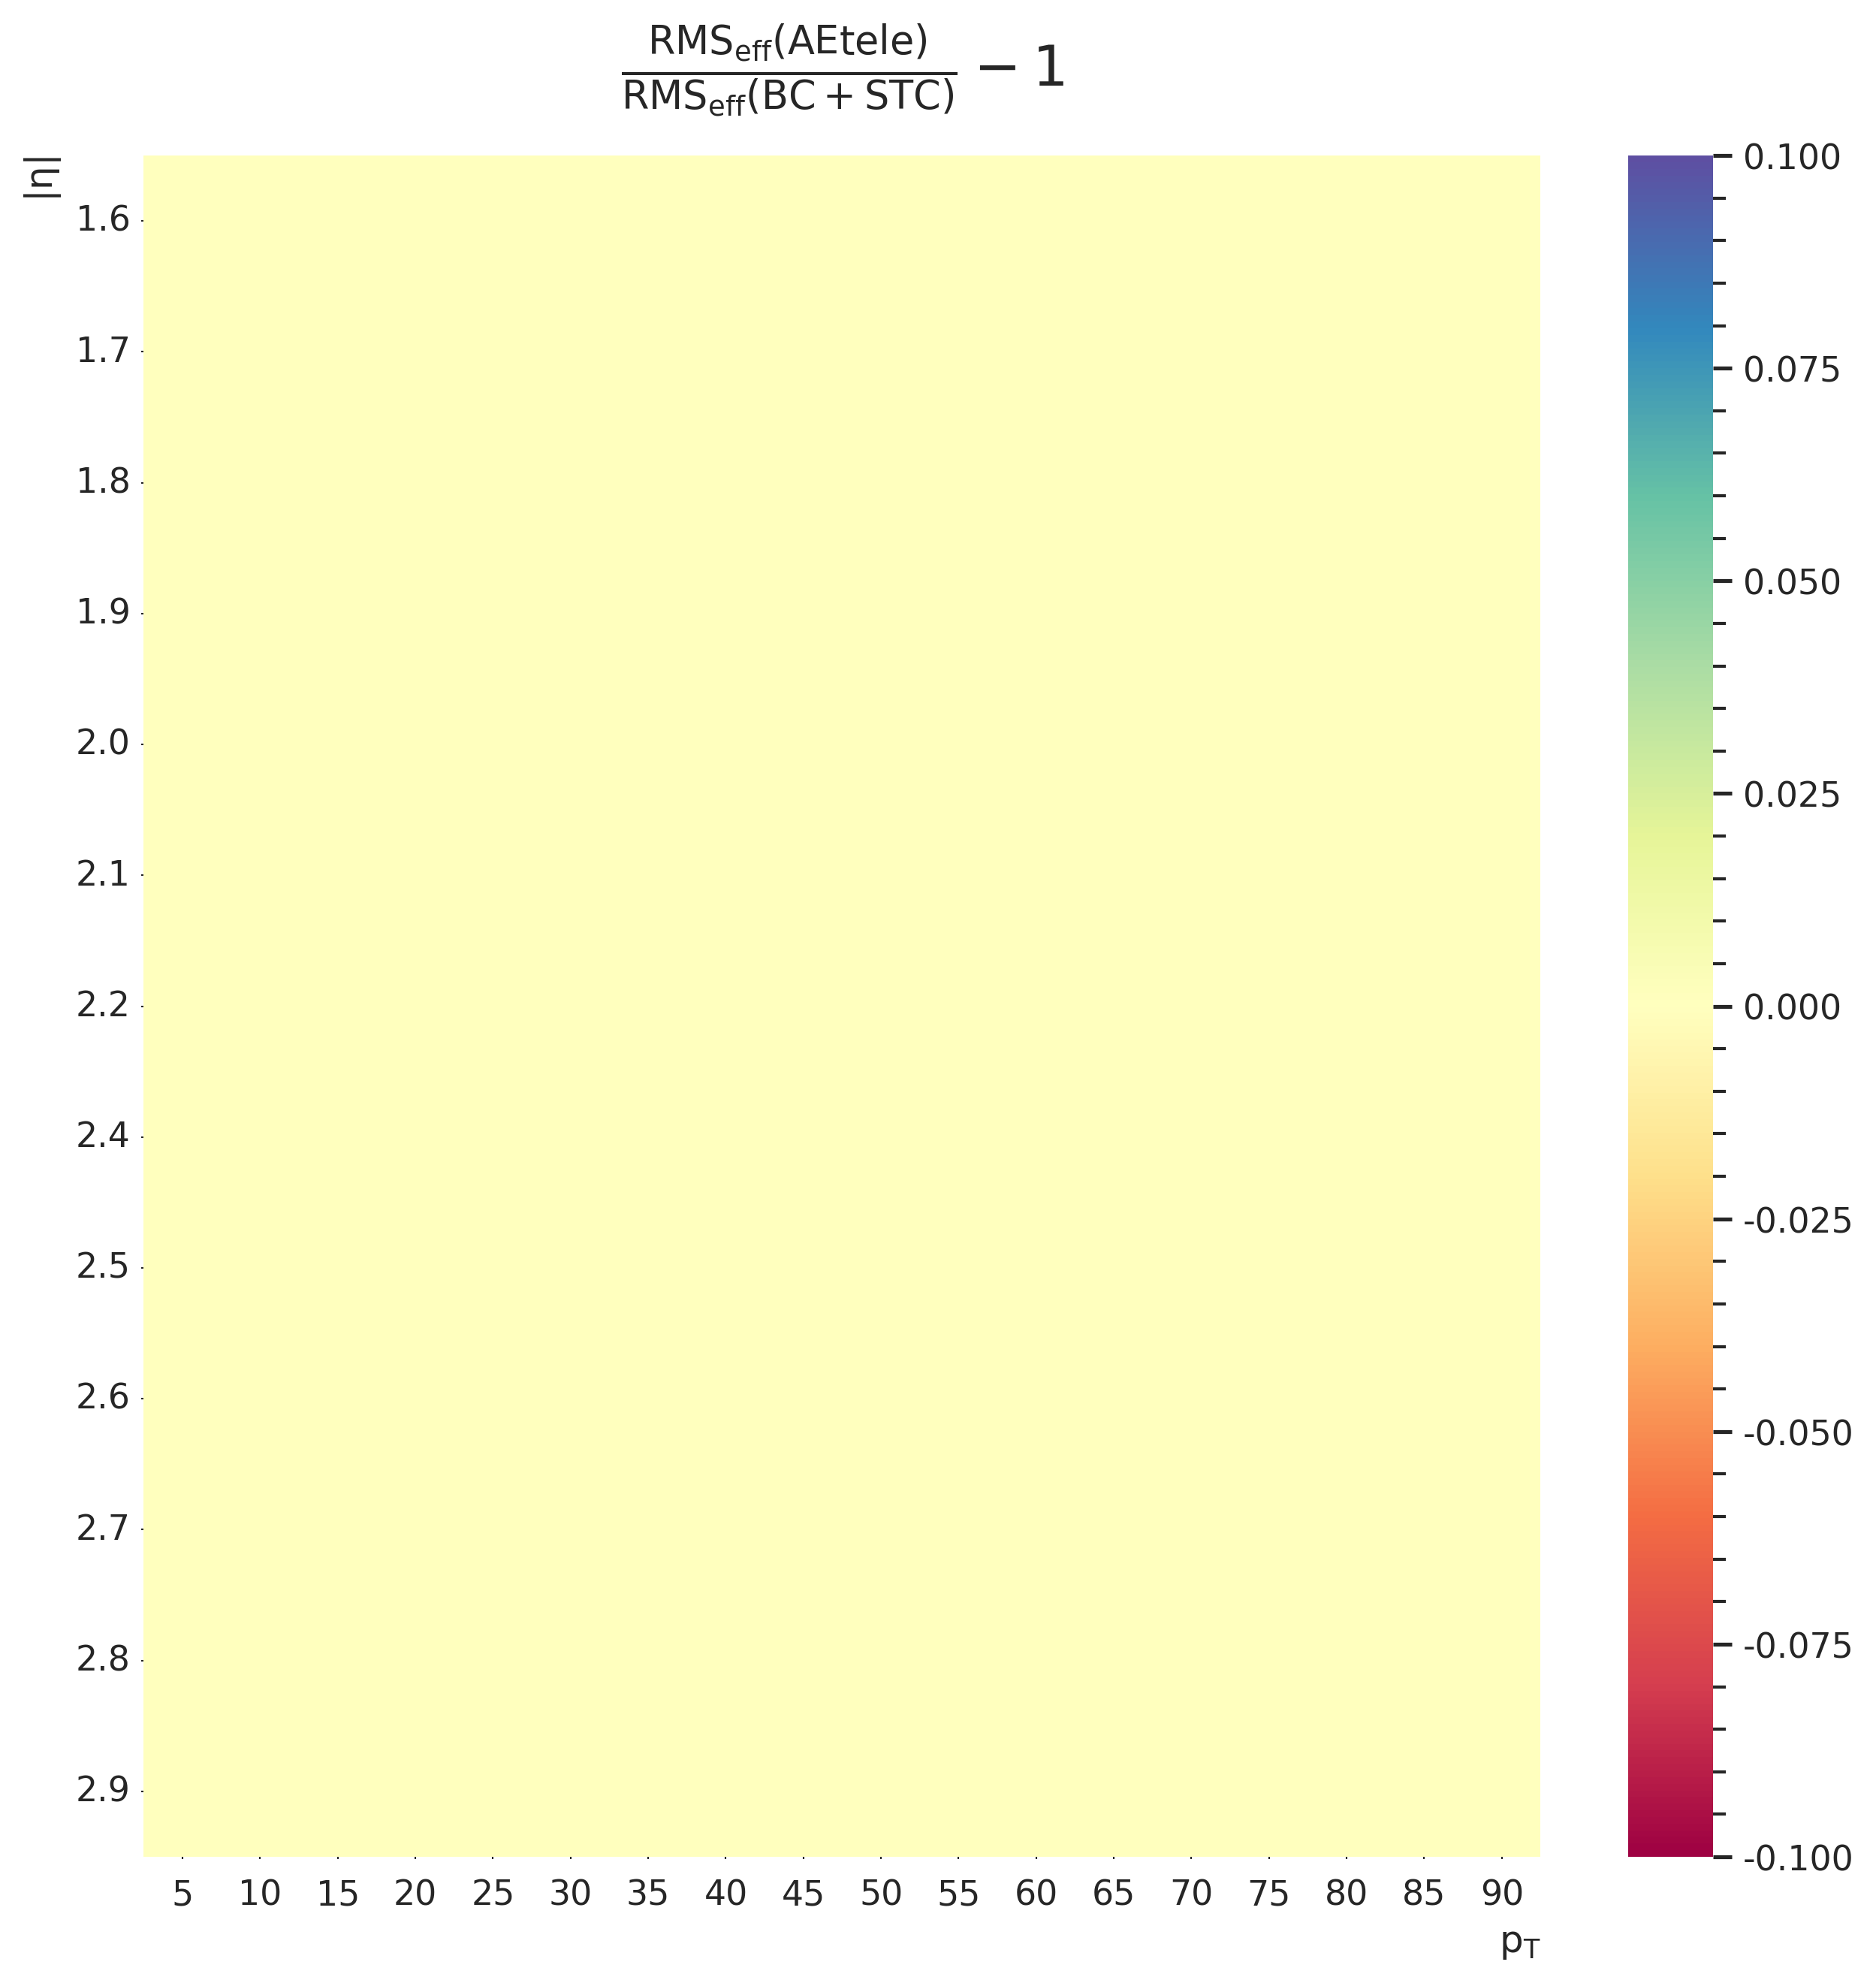

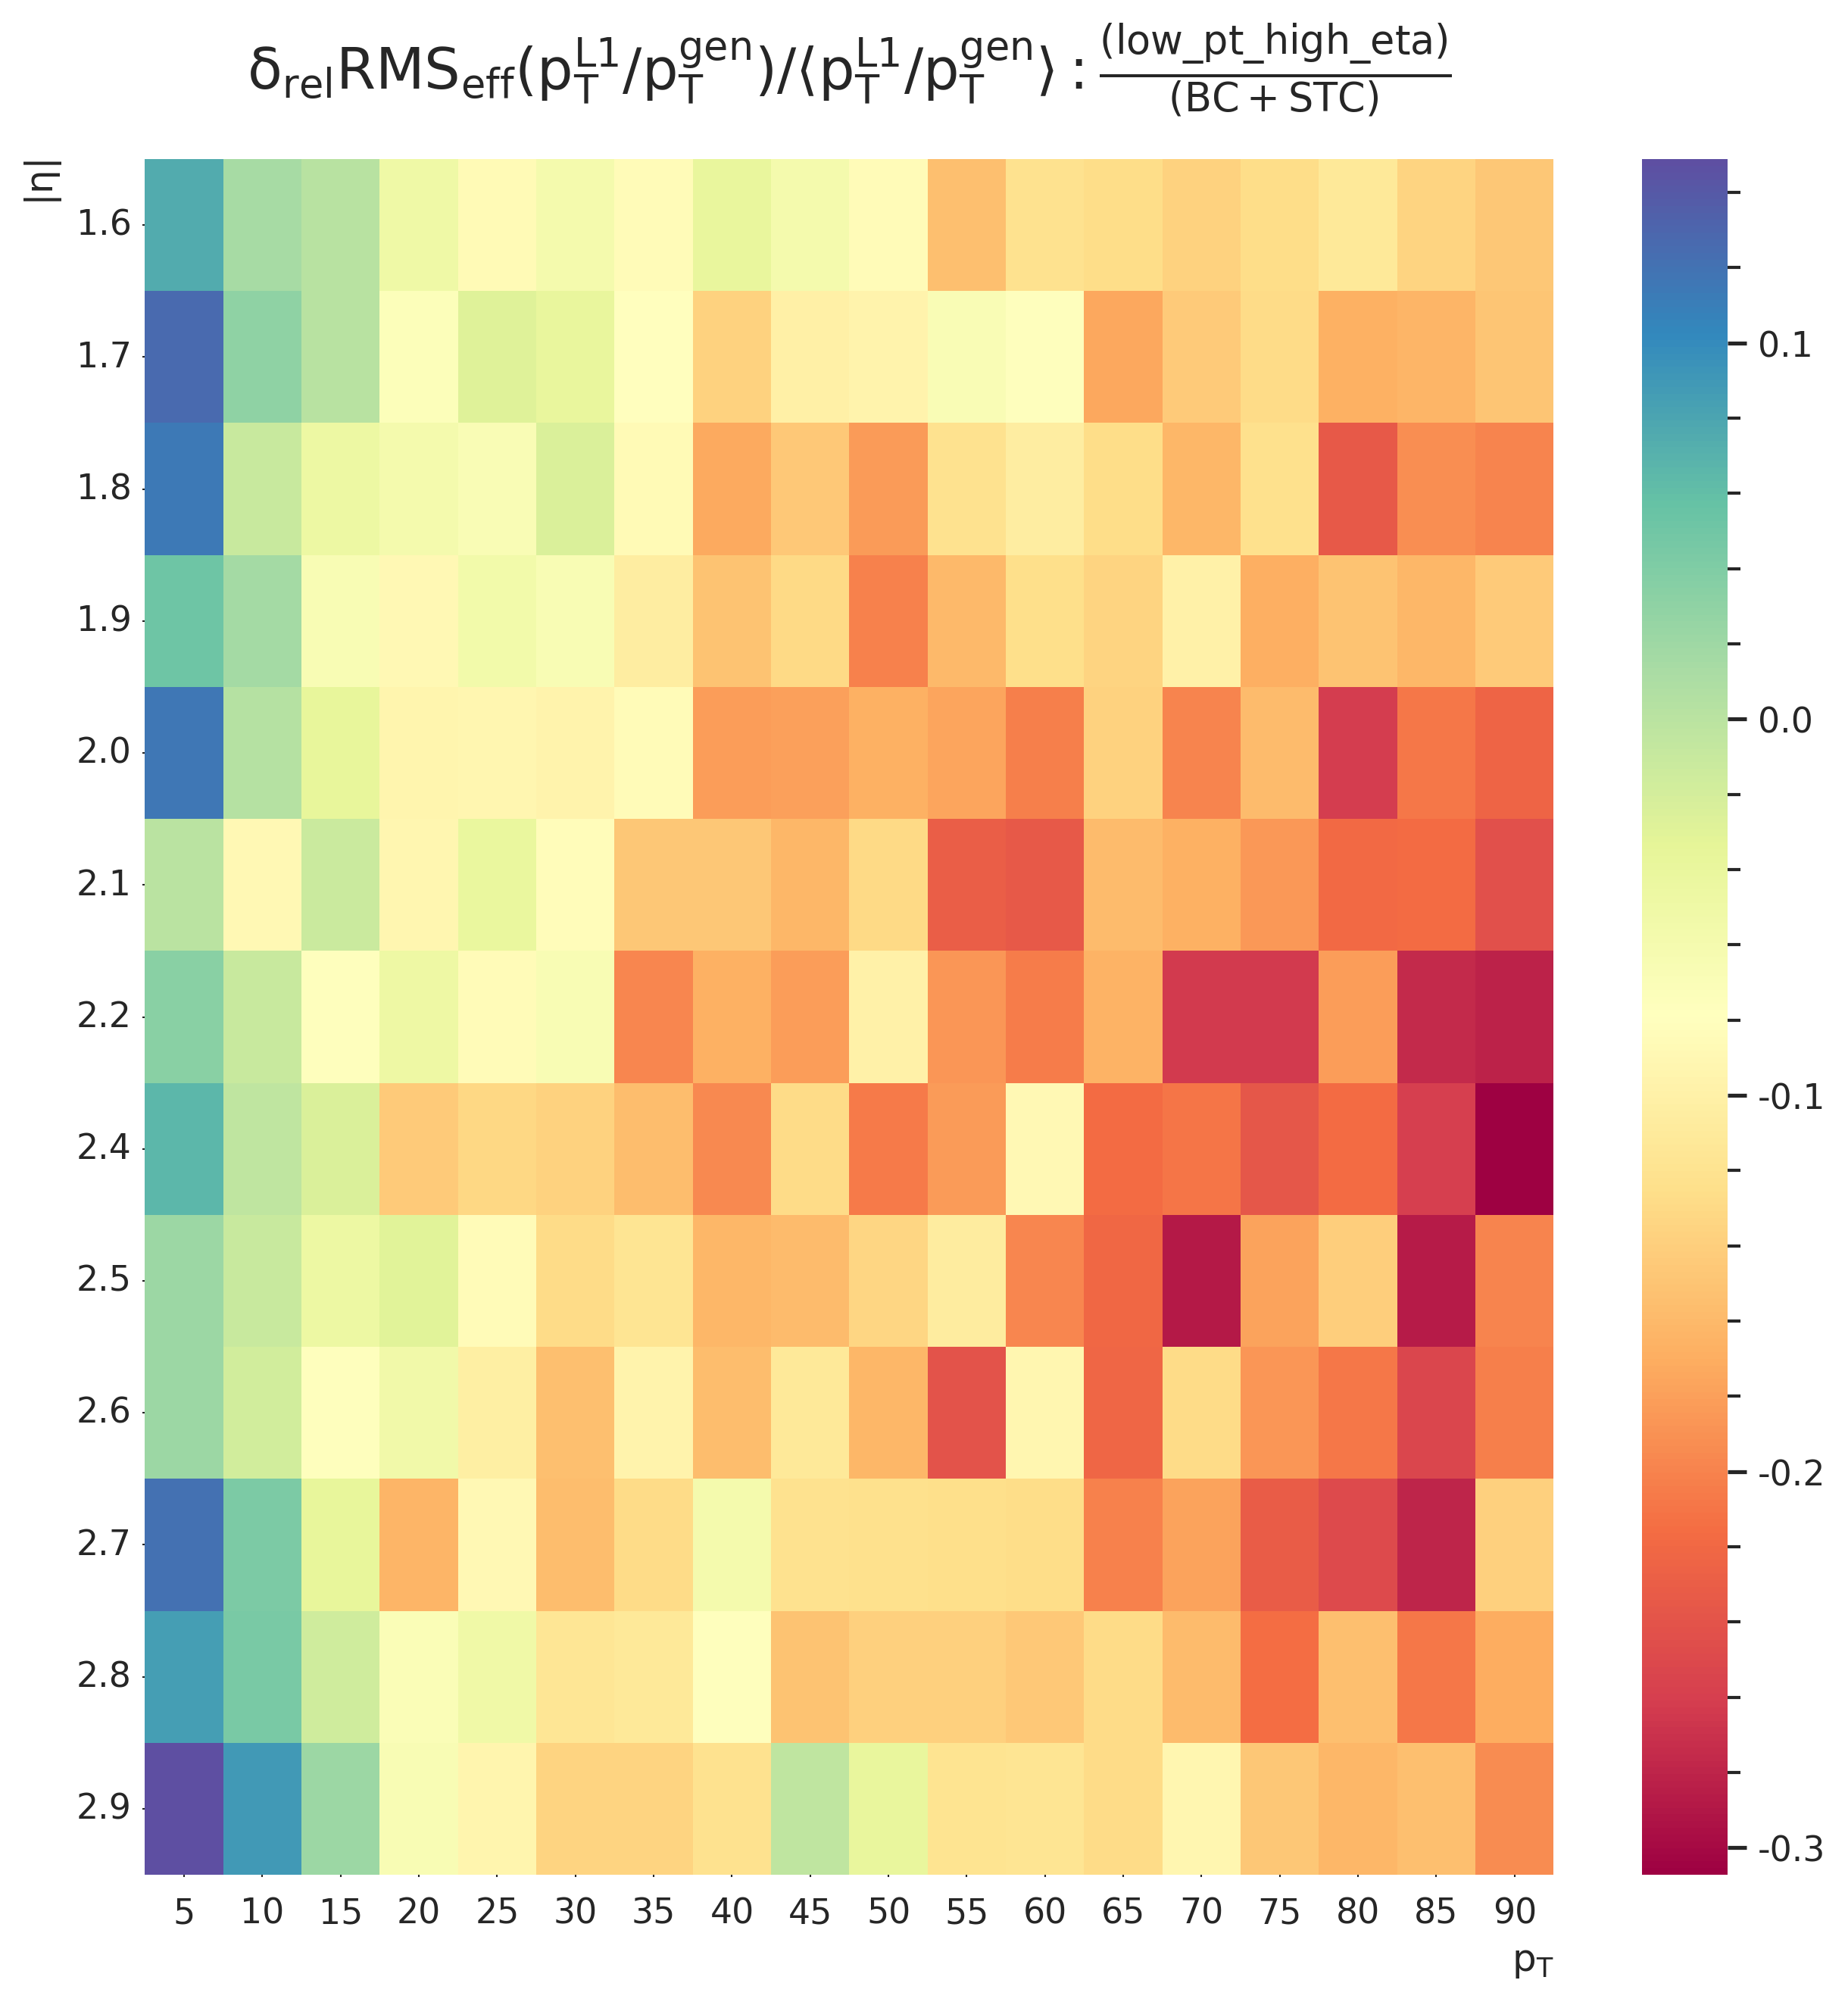

In [45]:
#Individual plots of the ones above: Ratio RMS_eff heatmaps
plt.close()
#sns.set(font_scale=1.0)
for ix, (name, df_algo) in enumerate(algo_cut.items()):
    
    fig, axes = plt.subplots()    
    df = ((both_eff_rms[name]['corr_eta_over_gen_pt']/both_means[name]['corr_eta_over_gen_pt'])/DENOM)-(DENOM/DENOM)
    df = df.reset_index().pivot(columns='genpart_binpt', index='genpart_bineta')
    axes.tick_params(left=True,bottom=True, width =0.5,length=0.8)
    sns.heatmap(df, cmap = 'Spectral',
                xticklabels=pt_bins,
                yticklabels=eta_bins,
               )
    #plt.title(legends[name])
    plt.xlabel(r'$p_{T}$')
    plt.ylabel('$|\eta|$')
    plt.yticks(rotation=0)
    plt.xticks(rotation=0)
    if name == 'AElphe':
        plt.title(r'$\delta_{rel}RMS_{eff}(p_{T}^{L1}/p_{T}^{gen}) / \langle p_{T}^{L1}/p_{T}^{gen}\rangle:\frac{(low\_pt\_high\_eta)}{(BC+STC)}$',fontsize=18,y=1.03)
        plt.savefig(fig_dir+'/rel_ratio_rms_eff_pt_eta'+name+'.png',dpi=300)
    else:
        plt.title(r'$\frac{RMS_{eff}('+name+')}{RMS_{eff}(BC+STC)}-1$',fontsize=18,y=1.03)
    plt.show()
    df={}

In [49]:
phys_res_tele = etaeffrmss['AEtele']['corr_eta_over_gen_pt']/etameans['AEtele']['corr_eta_over_gen_pt']
eta_tele = etameans['AEtele']['genpart_abseta']

phys_res_emd = etaeffrmss['AElphe']['corr_eta_over_gen_pt']/etameans['AElphe']['corr_eta_over_gen_pt']
eta_emd = etameans['AElphe']['genpart_abseta']

In [52]:
eta_emd.values

array([1.6497906, 1.7498177, 1.8506722, 1.9503016, 2.049803 , 2.1506746,
       2.2499712, 2.3495347, 2.4499617, 2.549822 , 2.6494315, 2.7502475,
       2.8494787], dtype=float32)

In [ ]:
print('Eff RMS vs eta')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = etameans[name]
    plt.plot(df, , color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0., 0.15)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$|\eta|$')
plt.ylabel(r'$RMS_{eff}(p_{T}^{L1}/p_{T}^{gen}) / \langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid()
plt.savefig(fig_dir+'/rms_eff_v_eta.png')
plt.show()

## Storing layer weights and eta corrections for external use

In [28]:
with open(fig_dir+'/layer_weights_photons_{}.pkl'.format(version), 'wb') as f:
    pickle.dump(layer_coeffs, f)
with open(fig_dir+'/lineareta_electrons_{}.pkl'.format(version), 'wb') as f:
    pickle.dump(corrs['eta'], f)